# KBO Predict For YOPS

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-

import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_column',100)
pd.set_option('display.max_row',500)
from pandas import DataFrame
from pandas import concat

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
from operator import itemgetter

import os
print(os.listdir("./input"))

from matplotlib import font_manager, rc #그래프 폰트 깨질경우 방지 부분
# fontpath= "./input/fontttf/NanumSquareB.ttf"
fontpath= "./input/NanumSquareB.ttf"
fp=font_manager.FontProperties(fname=fontpath)
font_name = font_manager.FontProperties(fname=fontpath).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['font.size']   = 15

import re
import requests
from bs4 import BeautifulSoup
import time

import math
from tqdm import tqdm
from collections import Counter
from sklearn.preprocessing import MinMaxScaler


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from math import sqrt
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

['.ipynb_checkpoints', 'NanumSquareB.ttf', '2019_kbo_for_kaggle_v2.csv', 'fontttf']


In [3]:
font_manager.FontProperties(fname=fontpath).get_name()

'NanumSquare'

In [4]:
!python --version

Python 3.9.7


In [5]:
#현재 데이터에서 발생하는 type error를 해결하기 위한 함수 생성해둠

def coerce_df_columns_to_numeric(df, column_list):
    df[column_list] = df[column_list].apply(pd.to_numeric, errors='coerce')

# 1. 데이터 불러오기

In [6]:
from pathlib import Path
# data_path = Path.joinpath(Path.cwd(),'data')
# train_path = Path.joinpath(Path.cwd(),'data','2019_kbo_for_kaggle_v2.csv')
data_path = Path.joinpath(Path.cwd(),'input')
train_path = Path.joinpath(Path.cwd(),'input','2019_kbo_for_kaggle_v2.csv')


regular_y=pd.read_csv(train_path)
regular_y.head()

,batter_name,age,G,PA,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,GB,SO,GDP,BU,fly,year,salary,war,year_born,hand2,cp,tp,1B,FBP,avg,OBP,SLG,OPS,p_year,YAB,YOPS
0,백용환,24.0,26.0,58.0,52.0,4.0,9.0,4.0,0.0,0.0,13.0,3.0,0.0,0.0,6.0,0.0,0.0,16.0,3.0,0.0,0.0,2013,2500,-0.055,1989-03-20,우투우타,포수,포수,5.0,6.0,0.173,0.259,0.250,0.509,2014,79.0,0.580
1,백용환,25.0,47.0,86.0,79.0,8.0,14.0,2.0,0.0,4.0,28.0,10.0,0.0,0.0,5.0,0.0,0.0,28.0,1.0,2.0,0.0,2014,2900,-0.441,1989-03-20,우투우타,포수,포수,8.0,5.0,0.177,0.226,0.354,0.580,2015,154.0,0.784
2,백용환,26.0,65.0,177.0,154.0,22.0,36.0,6.0,0.0,10.0,72.0,30.0,3.0,1.0,19.0,1.0,0.0,47.0,5.0,0.0,3.0,2015,6000,0.783,1989-03-20,우투우타,포수,포수,20.0,20.0,0.234,0.316,0.468,0.784,2016,174.0,0.581
3,백용환,27.0,80.0,199.0,174.0,12.0,34.0,7.0,0.0,4.0,53.0,15.0,2.0,1.0,19.0,1.0,1.0,52.0,6.0,3.0,2.0,2016,6000,-0.405,1989-03-20,우투우타,포수,포수,23.0,20.0,0.195,0.276,0.305,0.581,2017,17.0,0.476
4,백용환,28.0,15.0,20.0,17.0,2.0,3.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,3.0,2.0,0.0,0.0,2017,5500,-0.130,1989-03-20,우투우타,포수,포수,3.0,3.0,0.176,0.300,0.176,0.476,2018,47.0,0.691


In [7]:
regular_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   batter_name  1913 non-null   object 
 1   age          1913 non-null   float64
 2   G            1913 non-null   float64
 3   PA           1913 non-null   float64
 4   AB           1913 non-null   float64
 5   R            1913 non-null   float64
 6   H            1913 non-null   float64
 7   2B           1913 non-null   float64
 8   3B           1913 non-null   float64
 9   HR           1913 non-null   float64
 10  TB           1913 non-null   float64
 11  RBI          1913 non-null   float64
 12  SB           1913 non-null   float64
 13  CS           1913 non-null   float64
 14  BB           1913 non-null   float64
 15  HBP          1913 non-null   float64
 16  GB           1913 non-null   float64
 17  SO           1913 non-null   float64
 18  GDP          1913 non-null   float64
 19  BU    

In [8]:
regular_y.keys()

Index(['batter_name', 'age', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'TB',
       'RBI', 'SB', 'CS', 'BB', 'HBP', 'GB', 'SO', 'GDP', 'BU', 'fly', 'year',
       'salary', 'war', 'year_born', 'hand2', 'cp', 'tp', '1B', 'FBP', 'avg',
       'OBP', 'SLG', 'OPS', 'p_year', 'YAB', 'YOPS'],
      dtype='object')

In [9]:
regular_y = regular_y.loc[:,['batter_name', 'age', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B', '3B', 'HR', 'TB',
       'RBI', 'SB', 'CS', 'BB', 'HBP', 'GB', 'SO', 'GDP', 'BU', 'fly', 'year',
       'salary', 'war', 'year_born', 'hand2', 'cp', 'tp', 'FBP', 'avg', 'OBP', 'SLG', 'OPS', 'p_year',
       'YAB', 'YOPS']]
regular_y

,batter_name,age,G,PA,AB,R,H,1B,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,GB,SO,GDP,BU,fly,year,salary,war,year_born,hand2,cp,tp,FBP,avg,OBP,SLG,OPS,p_year,YAB,YOPS
0,백용환,24.0,26.0,58.0,52.0,4.0,9.0,5.0,4.0,0.0,0.0,13.0,3.0,0.0,0.0,6.0,0.0,0.0,16.0,3.0,0.0,0.0,2013,2500,-0.055,1989-03-20,우투우타,포수,포수,6.0,0.173,0.259,0.250,0.509,2014,79.0,0.580
1,백용환,25.0,47.0,86.0,79.0,8.0,14.0,8.0,2.0,0.0,4.0,28.0,10.0,0.0,0.0,5.0,0.0,0.0,28.0,1.0,2.0,0.0,2014,2900,-0.441,1989-03-20,우투우타,포수,포수,5.0,0.177,0.226,0.354,0.580,2015,154.0,0.784
2,백용환,26.0,65.0,177.0,154.0,22.0,36.0,20.0,6.0,0.0,10.0,72.0,30.0,3.0,1.0,19.0,1.0,0.0,47.0,5.0,0.0,3.0,2015,6000,0.783,1989-03-20,우투우타,포수,포수,20.0,0.234,0.316,0.468,0.784,2016,174.0,0.581
3,백용환,27.0,80.0,199.0,174.0,12.0,34.0,23.0,7.0,0.0,4.0,53.0,15.0,2.0,1.0,19.0,1.0,1.0,52.0,6.0,3.0,2.0,2016,6000,-0.405,1989-03-20,우투우타,포수,포수,20.0,0.195,0.276,0.305,0.581,2017,17.0,0.476
4,백용환,28.0,15.0,20.0,17.0,2.0,3.0,3.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,3.0,2.0,0.0,0.0,2017,5500,-0.130,1989-03-20,우투우타,포수,포수,3.0,0.176,0.300,0.176,0.476,2018,47.0,0.691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,이원석,32.0,128.0,543.0,479.0,74.0,144.0,93.0,30.0,1.0,20.0,236.0,93.0,2.0,1.0,52.0,7.0,1.0,103.0,10.0,0.0,5.0,2018,30000,3.315,1986-10-21,우투우타,3루수,3루수,59.0,0.301,0.374,0.493,0.867,2019,395.0,0.768
1909,조용호,28.0,68.0,225.0,191.0,34.0,52.0,44.0,7.0,1.0,0.0,61.0,10.0,11.0,2.0,25.0,3.0,0.0,39.0,4.0,6.0,0.0,2017,3100,0.215,1989-09-09,우투좌타,우익수,우익수,28.0,0.272,0.365,0.319,0.684,2018,13.0,0.154
1910,조용호,29.0,16.0,14.0,13.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,1.0,0.0,2018,6200,-0.271,1989-09-09,우투좌타,우익수,우익수,0.0,0.077,0.077,0.077,0.154,2019,188.0,0.720
1911,히메네스,27.0,70.0,299.0,279.0,37.0,87.0,57.0,17.0,2.0,11.0,141.0,46.0,8.0,2.0,12.0,4.0,1.0,48.0,4.0,0.0,4.0,2015,50000,2.365,1988-01-18,우투우타,3루수,3루수,16.0,0.312,0.344,0.505,0.849,2016,523.0,0.889


**기본적 데이터 변수들의 정보는 다음과 같다.**  
**Following table shows the description of variables.**

|**Number**|**Columns**|**Description**|   
|:----:|:----:|:----:|
|1|batter_name|타자 이름|
|2|age|타자 나이|
|3|G|출전게임수|
|4|PA|타석|
|5|AB|타수(타석-볼넷-사구-희생번트-희생플라이)|
|6|R|득점|
|7|H|안타(1루타+2루타+3루타+홈런)|
|8|1B|1루타|
|9|2B|2루타|
|10|3B|3루타|
|11|HR|홈런|
|12|TB|루타 수|
|13|RBI|타점|
|14|SB|도루 성공|
|15|CS|도루 실패|
|16|BB|볼넷|
|17|HBP|사구(몸에 맞는 볼)|
|18|GB|고의 4구|
|19|SO|삼진아웃|
|20|GDP|병살타|
|21|BU|희생타|
|22|fly|희생플라이|	
|23|year|해당 시즌|	
|24|salary|연봉|
|25|war|대체 선수 대비 승리 기여도|
|26|year_born|출생일|
|27|hand2|타석위치|	
|28|tp|통합포지션|	
|29|FBP|BB+HBP|	
|30|avg|타율|	
|31|OBP|출루율|	
|32|SLG|장타율|	
|33|OPS|OPS(OBP+SLG)|
|34|p_year|다음시즌|
|35|YAB|다음 시즌 타석 수|	
|36|YOPS|다음 시즌 OPS|	

  

In [10]:
'''
그래프 크기와 폰트 사이즈 조절
'''
figure_size          = (10,6) # 그래프 사이즈
title_font_size      =  24    # 제목 폰트크기
label_font_size      =  18    # 레이블 폰트크기
tick_label_font_size =  14    # 틱 레이블 폰트크기

# 2. 데이터 정제 및 처리

## 2.1. 범주형 변수 통합

In [11]:
Counter(regular_y['cp'])

Counter({'포수': 230,
         '2루수': 213,
         '유격수': 135,
         '1루수': 212,
         '중견수': 172,
         '3루수': 243,
         '좌익수': 240,
         '우익수': 200,
         '지명타자': 268})

### Year (년도)에 따른 데이터 양

count    1913.000000
mean     2011.032410
std         6.024791
min      1990.000000
25%      2007.000000
50%      2013.000000
75%      2016.000000
max      2018.000000
Name: year, dtype: float64

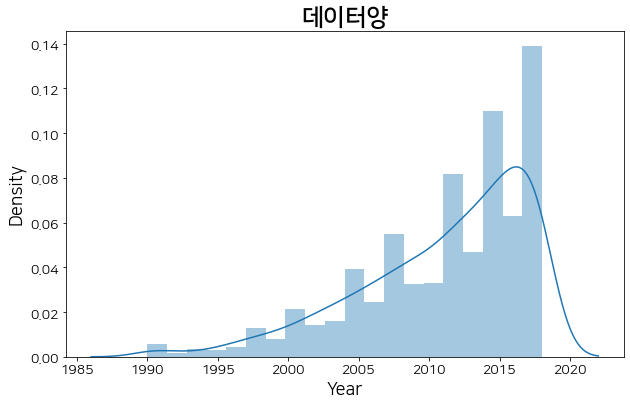

In [12]:
plt.figure(figsize=figure_size)

#distribution 'year'
sns.distplot(regular_y['year'])
plt.title('데이터양',fontproperties=fp,fontsize=title_font_size)
plt.xlabel('Year',fontsize=label_font_size)
plt.ylabel('Density',fontsize=label_font_size)
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)

#simple analytsis of 'year'
regular_y['year'].describe()

데이터의 양이 최근 년도로 편중 되있는것으로 확인된며,  
기본적인 데이터 분석에서도 중간값이 **2011년대**로 나오는것을 확인 할수 있다.  
  

### B (타수)

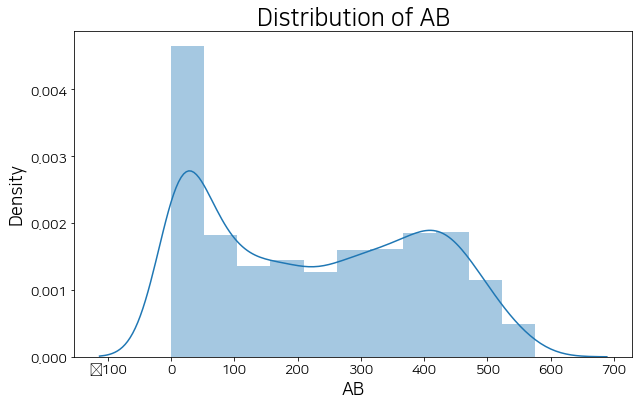

In [13]:
plt.figure(figsize=figure_size)
#distribution 'AB'
fig = sns.distplot(regular_y['AB'])
plt.title('Distribution of AB',fontsize=title_font_size)
plt.xlabel('AB',fontsize=label_font_size)
plt.ylabel('Density',fontsize=label_font_size)
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)

plt.show(fig)



In [14]:
#simple analysis 'AB'
regular_y['AB'].describe()

count    1913.000000
mean      228.465238
std       170.588573
min         0.000000
25%        56.000000
50%       221.000000
75%       383.000000
max       576.000000
Name: AB, dtype: float64

상당수의 타자들이 **100 회 이하의 타석**에 들어선것을 알수 있으며,  
기본적 데이터 분석에서도 **절반의 선수가 163 타석이하로 들어서는 것**을 알 수 있다.  
  

### OPS

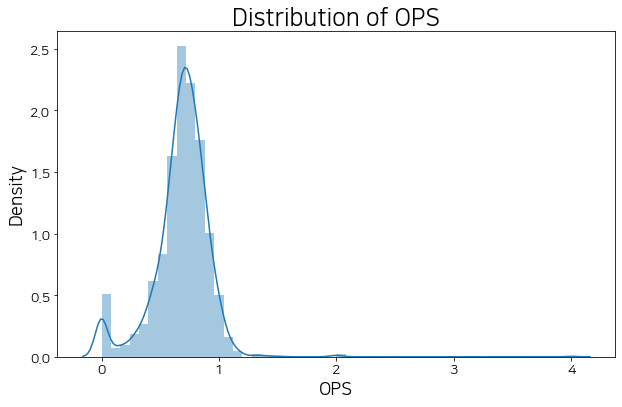

count    1899.000000
mean        0.679483
std         0.241919
min         0.000000
25%         0.589000
50%         0.706000
75%         0.813000
max         4.000000
Name: OPS, dtype: float64

In [15]:
plt.figure(figsize=figure_size)
#distribution 'OPS'
#OPS의 경우 null 값이 있으므로 해당 null 값들을 제외한다.
fig = sns.distplot(regular_y['OPS'].dropna())
plt.title('Distribution of OPS',fontsize=title_font_size)

plt.xlabel('OPS',fontsize=label_font_size)
plt.ylabel('Density',fontsize=label_font_size)
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)

plt.show(fig)

#simple analysis 'OPS'
regular_y['OPS'].describe()

**OPS**의 경우 데이터상 0값을 가지고 있는 선수들이 있으므로 0의 경우 상대적 높게 관측되지만,  
어느정도 정규분포를 따른다고 이야기 할 수 있다.
  

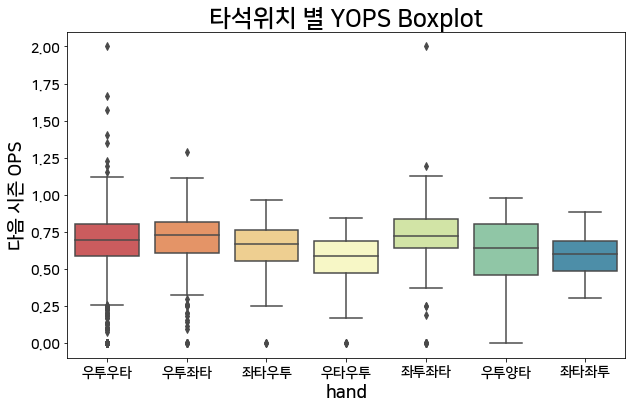

In [16]:
# fkd1= list(Counter(regular_y['hand2']).keys())
# fkd2= list(Counter(regular_y['hand2']).values())

plt.figure(figsize=figure_size)

# 설치된 폰트 출력 가능
sns.boxplot(x='hand2',y="YOPS", data=regular_y,palette="Spectral")
plt.title('타석위치 별 YOPS Boxplot',fontproperties=fp,size=title_font_size)
plt.xticks(fontproperties=fp,fontsize=tick_label_font_size)
plt.yticks(fontproperties=fp,fontsize=tick_label_font_size)
plt.xlabel('hand',fontproperties=fp,size=label_font_size)
plt.ylabel('다음 시즌 OPS',fontproperties=fp,size=label_font_size);


## 2.2. 타석위치, 통합 포지션 만들기

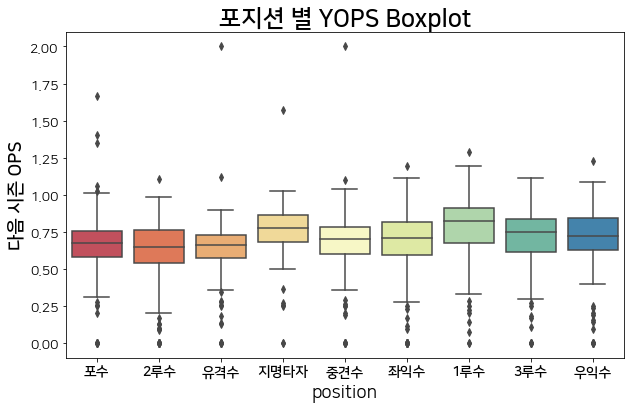

In [17]:
# plt.figure(figsize=(20,9))
plt.figure(figsize=figure_size)
sns.boxplot(x='tp',y="YOPS", data=regular_y,palette="Spectral")
plt.title('포지션 별 YOPS Boxplot',fontproperties=fp,size=title_font_size)
plt.xticks(fontproperties=fp,fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.xlabel('position',size=label_font_size)
plt.ylabel('다음 시즌 OPS',fontproperties=fp,size=label_font_size);

In [18]:
#스탯티즈에서 가져온 타석 위치에 대한 통일 작업 실시 (좌타,우타,양타만 확인하고 바꾸는 방식으로 진행했다)
regular_y['hand2']=regular_y['hand2'].replace('우투우타','우타')
regular_y['hand2']=regular_y['hand2'].replace('우타우투','우타')
regular_y['hand2']=regular_y['hand2'].replace('우투양타','양타')
regular_y['hand2']=regular_y['hand2'].replace('우투좌타','좌타')

regular_y['hand2']=regular_y['hand2'].replace('좌투좌타','좌타')
regular_y['hand2']=regular_y['hand2'].replace('좌타좌투','좌타')
regular_y['hand2']=regular_y['hand2'].replace('좌타우투','좌타')

regular_y['hand2'].unique()

array(['우타', '좌타', '양타'], dtype=object)

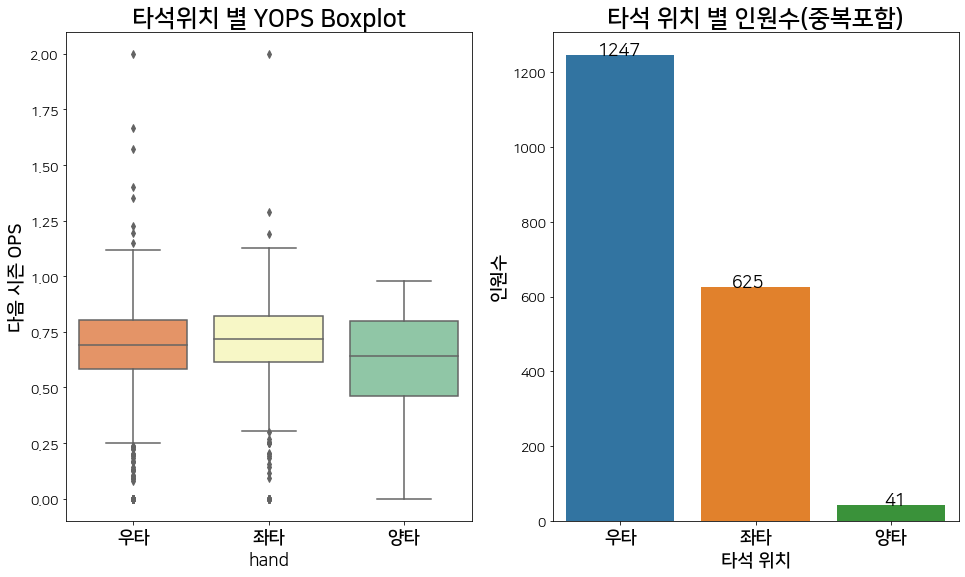

In [19]:
plt.figure(figsize=(16,9))

plt.subplot(121)
sns.boxplot(x='hand2',y="YOPS", data=regular_y,palette="Spectral")
plt.title('타석위치 별 YOPS Boxplot',fontproperties=fp,size=title_font_size)
plt.xticks(fontproperties=fp,fontsize=label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.xlabel('hand',size=label_font_size)
plt.ylabel('다음 시즌 OPS',fontproperties=fp,size=label_font_size)

fkd1= list(Counter(regular_y['hand2']).keys())
fkd2= list(Counter(regular_y['hand2']).values())

plt.subplot(122)
sns.barplot(x=fkd1,y=fkd2)
plt.title('타석 위치 별 인원수(중복포함)',fontproperties=fp,size=title_font_size)
plt.xticks(fontproperties=fp,fontsize=label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.xlabel('타석 위치',fontproperties=fp,size=label_font_size)
plt.ylabel('인원수',fontproperties=fp,size=label_font_size)
for x,y in zip(range(0,len(fkd1)),fkd2):
    if len(str(y))==2:
        plt.text(x-0.05,y,fkd2[x],size=label_font_size)
    else:
        plt.text(x-0.175,y,fkd2[x],size=label_font_size)

In [20]:
#스탯티즈를 통해서 대체된 포지션의 경우에 대한 포지션 통합 작업
#지명타자의 경우 외야수 출신인 이범호를 제외하고는 전부 지명타자 출신이어서 내야수로 할당하였다.
regular_y['tp']=regular_y['tp'].replace('2루수','내야수')
regular_y['tp']=regular_y['tp'].replace('지명타자','내야수')
regular_y['tp']=regular_y['tp'].replace('유격수','내야수')
regular_y['tp']=regular_y['tp'].replace('3루수','내야수')
regular_y['tp']=regular_y['tp'].replace('1루수','내야수')

regular_y['tp']=regular_y['tp'].replace('우익수','외야수')
regular_y['tp']=regular_y['tp'].replace('중견수','외야수')
regular_y['tp']=regular_y['tp'].replace('좌익수','외야수')

regular_y['tp'].unique()

array(['포수', '내야수', '외야수'], dtype=object)

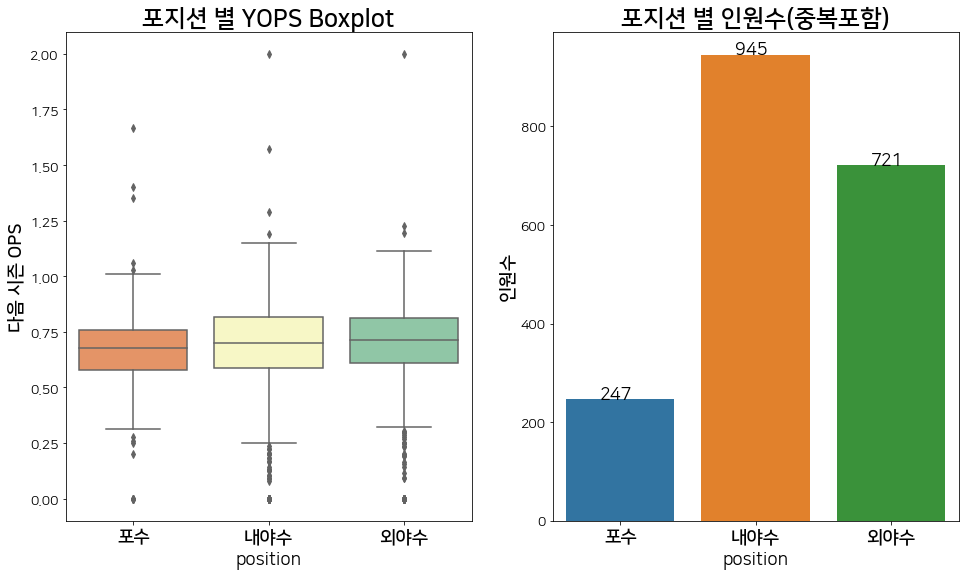

In [21]:
plt.figure(figsize=(16,9))

plt.subplot(121)
sns.boxplot(x='tp',y="YOPS", data=regular_y,palette="Spectral")
plt.title('포지션 별 YOPS Boxplot',fontproperties=fp,size=title_font_size)
plt.xticks(fontproperties=fp,fontsize=label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.xlabel('position',size=label_font_size)
plt.ylabel('다음 시즌 OPS',fontproperties=fp,size=label_font_size)

fkd1= list(Counter(regular_y['tp']).keys())
fkd2= list(Counter(regular_y['tp']).values())
plt.subplot(122)
sns.barplot(x=fkd1,y=fkd2)
plt.title('포지션 별 인원수(중복포함)',fontproperties=fp,size=title_font_size)
plt.xticks(fontproperties=fp,fontsize=label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.xlabel('position',size=label_font_size)
plt.ylabel('인원수',fontproperties=fp,size=label_font_size)
for x,y in zip(range(0,len(fkd1)),fkd2):
    if len(str(y))==2:
        plt.text(x-0.05,y,fkd2[x],size=label_font_size)
    else:
        plt.text(x-0.15,y,fkd2[x],size=label_font_size)

#### 포지션(투타)

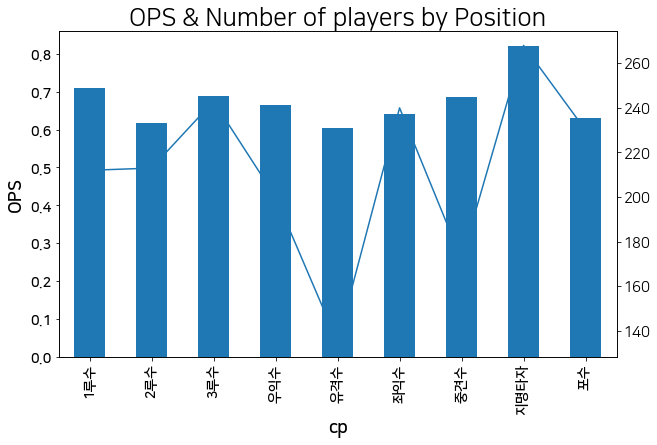

In [22]:
#각 포지션 별로 카운트와, 평균값 그래프로 도출
#그룹별로 해서 그래프로 도출하기
#subplot visualisation
plt.figure(figsize=figure_size)
plt.subplots_adjust(hspace=0.4)

plt.tight_layout()
plt.title('OPS & Number of players by Position',size=25)

plt.xticks(fontproperties=fp,fontsize=tick_label_font_size)
plt.yticks(fontproperties=fp,fontsize=tick_label_font_size)

plt.xlabel('cp',fontproperties=fp, fontsize=label_font_size)
plt.ylabel('OPS',fontproperties=fp,fontsize=label_font_size)

#number of players for each position
#plt.subplot(2,1,1)
regular_y.groupby(['cp'])['cp'].value_counts().plot(secondary_y=True)

#mean of 'OPS' by each position
#plt.subplot(2,1,2)
regular_y.groupby(['cp'])['OPS'].mean().plot.bar()

plt.show()

#### **포지션**의 경우  
#### 내외야 전반적으로, **가장 보편적인 우투우타의 선수가 가장 많은 것으로 관측**되며,  
#### 포수의 경우 **좌투선수의 데이터가 없는것으로 관측** 된다.  
  
#### 이는 **포수가 좌투 일 경우**, **도루저지 혹은 송구 시 우타자에 의한 간섭 혹은 방해**가 생기므로,  
#### **우투가 유리하여 일어난 현상**으로 보인다.  

#### **포지션별 OPS**의 경우,  
#### **내야수(좌투좌타)가 평균적으로 가장 높은 것**으로 관측되며,
#### **내야수(우투양타)가 평균적으로 가장 낮은 것**으로 관측된다.
  
#### 포지션의 경우 기재되지 않은 값(null) 값이 다수 존재하므로,  
#### 관측 대상에서는 제외한다.  


In [23]:
del regular_y['cp']
del regular_y['year_born']
del regular_y['p_year']

## 2.3. 결측치 처리

In [24]:
regular_y[regular_y.isnull()['YOPS']]

,batter_name,age,G,PA,AB,R,H,1B,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,GB,SO,GDP,BU,fly,year,salary,war,hand2,tp,FBP,avg,OBP,SLG,OPS,YAB,YOPS
188,전민재,19.0,12.0,8.0,8.0,2.0,3.0,2.0,1.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2018,2700,0.047,우타,내야수,0.0,0.375,0.375,0.500,0.875,0.0,NaN
607,최윤석,30.0,21.0,33.0,32.0,3.0,7.0,7.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,2017,5200,-0.343,우타,내야수,0.0,0.219,0.219,0.219,0.438,0.0,NaN
691,양원혁,27.0,7.0,6.0,5.0,3.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2018,2900,0.096,좌타,내야수,1.0,0.400,0.500,0.400,0.900,0.0,NaN
715,양종민,22.0,2.0,4.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2012,3200,0.018,양타,내야수,0.0,0.250,0.250,0.250,0.500,0.0,NaN
878,이준수,25.0,47.0,74.0,65.0,6.0,13.0,10.0,3.0,0.0,0.0,16.0,6.0,0.0,0.0,3.0,3.0,0.0,21.0,0.0,2.0,1.0,2013,3400,-0.081,우타,포수,6.0,0.200,0.264,0.246,0.510,0.0,NaN
979,박계범,19.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015,2700,0.016,우타,내야수,0.0,NaN,NaN,NaN,NaN,0.0,NaN
1042,지성준,21.0,9.0,12.0,12.0,1.0,3.0,2.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,2015,2700,-0.059,우타,포수,0.0,0.250,0.250,0.333,0.583,0.0,NaN
1183,백승룡,30.0,33.0,62.0,52.0,3.0,12.0,11.0,1.0,0.0,0.0,13.0,3.0,3.0,0.0,6.0,3.0,0.0,20.0,0.0,1.0,0.0,2012,3000,0.253,우타,내야수,9.0,0.231,0.344,0.250,0.594,0.0,NaN
1316,황진수,23.0,28.0,20.0,18.0,2.0,2.0,1.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,0.0,9.0,1.0,1.0,0.0,2012,2400,-0.117,양타,내야수,1.0,0.111,0.158,0.167,0.325,0.0,NaN
1420,강동관,20.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016,2700,-0.046,우타,포수,0.0,0.000,0.000,0.000,0.000,0.0,NaN


In [25]:
regular_y[regular_y['batter_name']=='최윤석']

,batter_name,age,G,PA,AB,R,H,1B,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,GB,SO,GDP,BU,fly,year,salary,war,hand2,tp,FBP,avg,OBP,SLG,OPS,YAB,YOPS
603,최윤석,23.0,47.0,93.0,76.0,13.0,7.0,5.0,2.0,0.0,0.0,9.0,2.0,7.0,1.0,8.0,1.0,0.0,19.0,1.0,7.0,1.0,2010,2400,-0.777,우타,내야수,9.0,0.092,0.186,0.118,0.304,156.0,0.696
604,최윤석,24.0,82.0,209.0,156.0,21.0,38.0,32.0,4.0,1.0,1.0,47.0,9.0,4.0,4.0,32.0,7.0,0.0,38.0,2.0,14.0,0.0,2011,3200,1.066,우타,내야수,39.0,0.244,0.395,0.301,0.696,170.0,0.612
605,최윤석,25.0,109.0,213.0,170.0,17.0,39.0,37.0,1.0,0.0,1.0,43.0,15.0,6.0,5.0,33.0,2.0,0.0,36.0,4.0,7.0,1.0,2012,5000,0.763,우타,내야수,35.0,0.229,0.359,0.253,0.612,67.0,0.595
606,최윤석,29.0,11.0,17.0,16.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,2016,5700,-0.423,우타,내야수,1.0,0.125,0.176,0.125,0.301,32.0,0.438
607,최윤석,30.0,21.0,33.0,32.0,3.0,7.0,7.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,2017,5200,-0.343,우타,내야수,0.0,0.219,0.219,0.219,0.438,0.0,NaN
608,최윤석,31.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2018,4800,0.003,우타,내야수,2.0,NaN,1.000,NaN,NaN,12.0,0.650


In [26]:
regular_y[regular_y['batter_name']=='양종민']

,batter_name,age,G,PA,AB,R,H,1B,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,GB,SO,GDP,BU,fly,year,salary,war,hand2,tp,FBP,avg,OBP,SLG,OPS,YAB,YOPS
712,양종민,19.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2009,2400,0.006,양타,내야수,0.0,0.000,0.000,0.000,0.000,9.0,0.422
713,양종민,20.0,7.0,10.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,2010,2400,-0.052,양타,내야수,1.0,0.111,0.200,0.222,0.422,55.0,0.573
714,양종민,21.0,58.0,64.0,55.0,11.0,13.0,11.0,2.0,0.0,0.0,15.0,5.0,0.0,3.0,5.0,0.0,0.0,21.0,1.0,4.0,0.0,2011,2500,-0.105,양타,내야수,5.0,0.236,0.300,0.273,0.573,4.0,0.500
715,양종민,22.0,2.0,4.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2012,3200,0.018,양타,내야수,0.0,0.250,0.250,0.250,0.500,0.0,NaN
716,양종민,23.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013,2700,0.000,양타,내야수,0.0,NaN,NaN,NaN,NaN,4.0,0.000
717,양종민,24.0,5.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2014,2900,-0.077,양타,내야수,0.0,0.000,0.000,0.000,0.000,16.0,0.534
718,양종민,28.0,21.0,15.0,14.0,5.0,4.0,3.0,0.0,1.0,0.0,6.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,0.0,0.0,2018,2900,-0.031,양타,내야수,1.0,0.286,0.333,0.429,0.762,44.0,0.352


In [27]:
regular_y['YOPS']=regular_y['YOPS'].fillna(0.00000)

# 3. 핵심변수 파악

## 3.1. 전체 변수간 상관관계 및 목적변수와의 상관관계

In [28]:
cor=regular_y.corr()

regular_y2=regular_y.copy()
del regular_y2['BB']
del regular_y2['HBP']
del regular_y2['year']
del regular_y2['1B']
del regular_y2['YAB']
del regular_y2['PA']
del regular_y2['batter_name']
del regular_y2['hand2']
del regular_y2['tp']

## 3.2. Correlation

<function matplotlib.pyplot.show(close=None, block=None)>

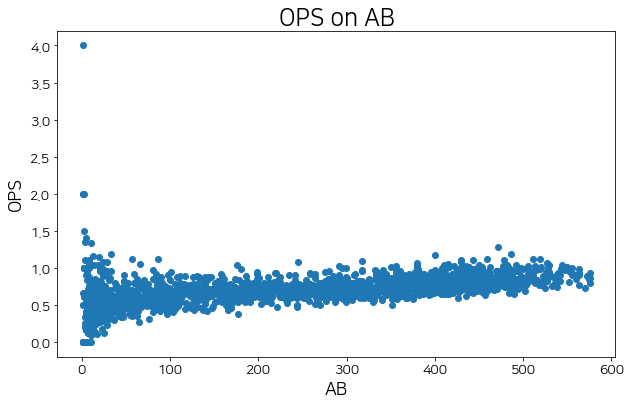

In [29]:
#OPS vs AB
plt.figure(figsize=figure_size)
plt.scatter(regular_y['AB'],regular_y['OPS'])
plt.title("OPS on AB",fontsize=title_font_size)
plt.xlabel("AB",fontsize=label_font_size)
plt.ylabel("OPS",fontsize=label_font_size)
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.show

### **OPS**는 **AB(타석)** 수에 **비례하여 상승** 하는것으로 보인다  
### 이와 같은 경우는 **성적이 좋은선수 (OPS가 높을 가능성이 높음)** 가   
### 꾸준히 타석에 들어서기 때문일 가능성이 제기된다. 
  

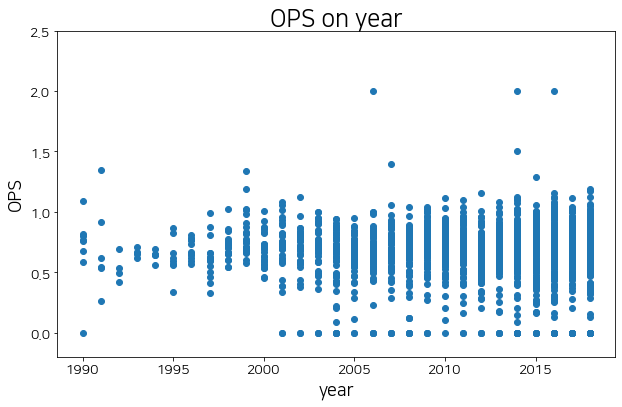

In [30]:
#Year vs OPS
plt.figure(figsize=figure_size)
plt.scatter(regular_y['year'],regular_y['OPS'])
plt.title('OPS on year',fontsize=title_font_size)
plt.xlabel('year',fontsize=label_font_size)
plt.ylabel('OPS',fontsize=label_font_size)
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.ylim(-0.2,2.5)
plt.show()

**OPS**의 **year** 별 분포는 대부분 비슷한 수준으로 형성되있으나,  
몇몇 outlier 와 2005년 이전에 값의 부재를 확인 할수 있다.

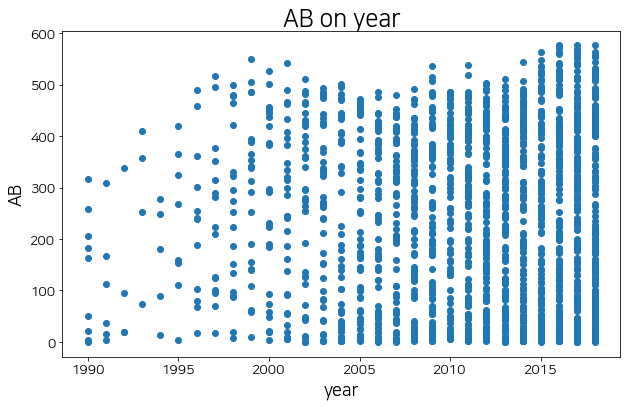

In [31]:
#'year' vs 'AB'
plt.figure(figsize=figure_size)
plt.scatter(regular_y['year'],regular_y['AB'])
plt.title('AB on year',fontsize=title_font_size)
plt.xlabel('year',fontsize=label_font_size)
plt.ylabel('AB',fontsize=label_font_size)
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.show()

## 3.3. 기타 데이터

### 선수

In [32]:
#count of unique values
regular_y['batter_name'].nunique()

338

#### **데이터 내에 총 338명의 선수**가 있다.

# 4.  Advanced EDA (OPS related)

### 기본적인 EDA 분석후 세부 EDA와 OPS (Target) 관련 변수들에 대해 알아본다.

## 4.1. Correlation (OPS)

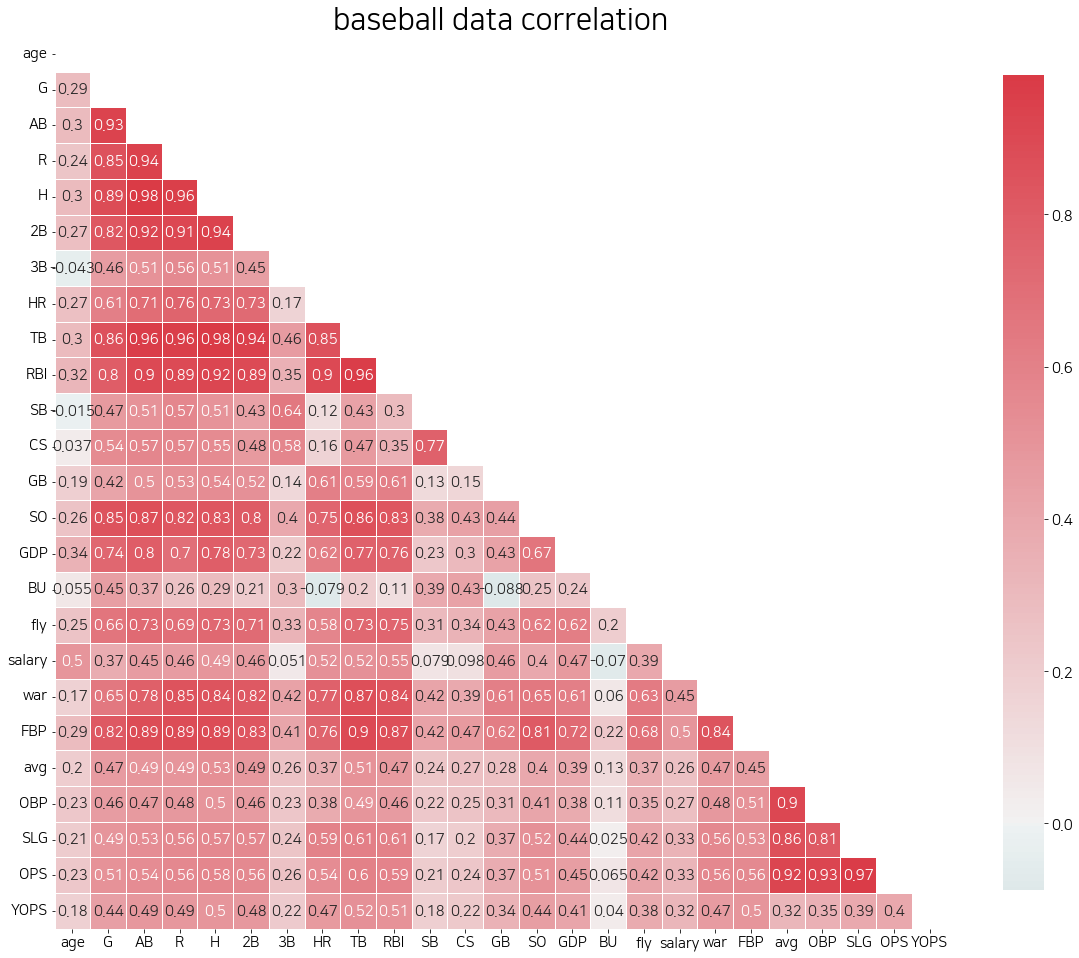

In [33]:
cor=regular_y2.corr()

mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,20))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":0.75},annot=True)
plt.title('baseball data correlation',size=30)
ax.set_xticklabels(list(regular_y2.columns),size=15)
ax.set_yticklabels(list(regular_y2.columns),size=15,rotation=0);



Correlation 으로 알아보면

OPS 측면
avg, SLG, OBP 가 OPS와 높은 상관관계를 가지는것을 알수있다.
이는 OPS가 SLG와 OBP로 이루어져 잇는것을 통해 설명 가능하며,
avg는 SLG와 OBP에 영향을 미치기 때문에 위와 같은 결과를 예측 할 수 있다.

### Corrleation (OPS on AB)

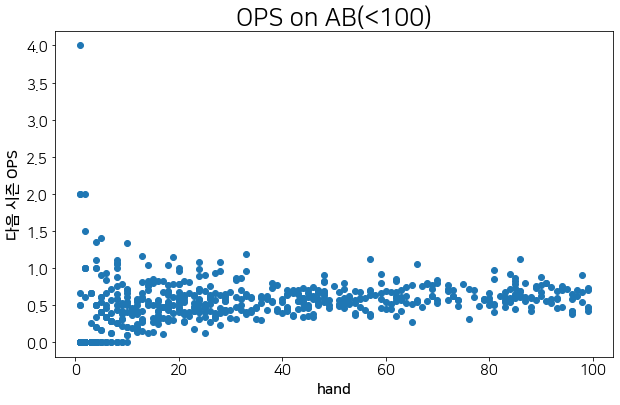

In [34]:
#100타석 이하의 OPS
plt.figure(figsize=figure_size)
data_ab100 = regular_y.loc[regular_y['AB']<100]
plt.scatter(data_ab100['AB'],data_ab100['OPS'])
plt.title('OPS on AB(<100)',size=25)
plt.xlabel('AB')
plt.ylabel('OPS')

# plt.xticks(fontproperties=fp,fontsize=25)
# plt.yticks(fontsize=25)
# plt.xlabel('hand',size=30)
# plt.ylabel('다음 시즌 OPS',fontproperties=fp,size=30);
plt.xlabel('hand',fontproperties=fp,size=15)
plt.ylabel('다음 시즌 OPS',fontproperties=fp,size=15);



plt.show()

#50타석 이전의 경우 변동성이 높으므로 50타석 이상의 선수들로 사용.

### 위의 그래프에서 관촬되었듯이,  
### **50타석 이하의 경우, 변동성이 높은 분포**를 보이며,  
### 이는 모델의 예측성을 낮추므로,   
### **50타석이상의 결과값으로 모델링을 진행**한다.

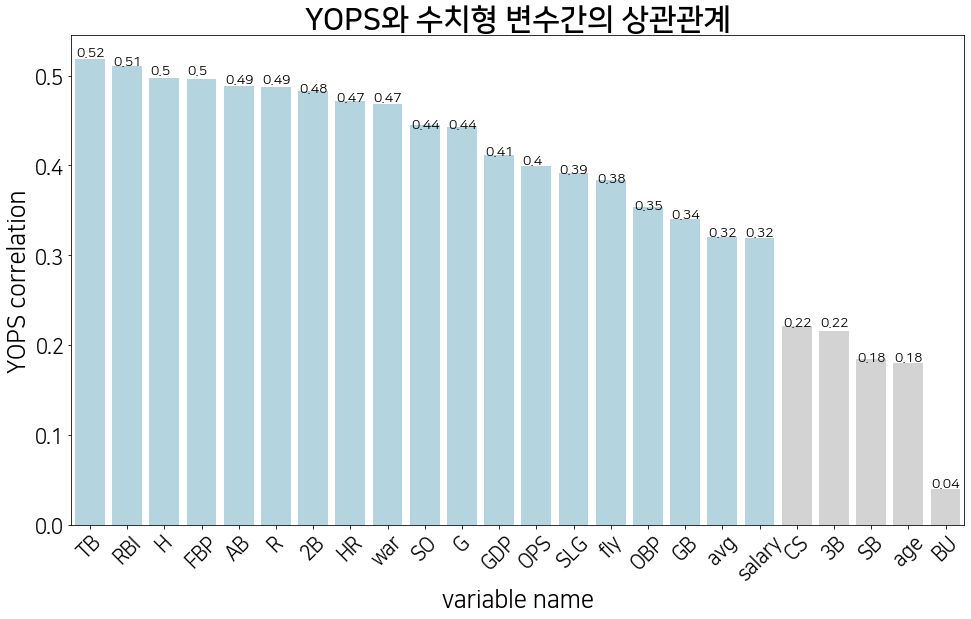

In [35]:
cor=regular_y2.corr()

f,ax=plt.subplots(figsize=(16,9))
ax=sns.barplot(x=cor['YOPS'].sort_values(ascending=False)[1:].keys(), y=cor['YOPS'].sort_values(ascending=False)[1:].values,
            palette=['lightblue' if _y >0.3  else 'lightgrey' if (_y > (-0.1) and ( _y <= 0.3)) else 'lightcoral' for _y in list(cor['YOPS'].sort_values(ascending=False)[1:].values) ])
plt.xticks(fontsize=20,rotation=45)
plt.yticks(fontsize=20)
plt.xlabel('variable name',size=title_font_size)
plt.ylabel('YOPS correlation',size=title_font_size)
plt.title('YOPS와 수치형 변수간의 상관관계',fontproperties=fp,size=30)

tk=[round(i,2) for i in cor['YOPS'].sort_values(ascending=False)[1:].values]
for x,y in zip(range(0,len(tk)),tk):
        plt.text(x-0.375,y+0.0025,tk[x],size=tick_label_font_size);

## 4.2. 핵심 변수들 분포 및 상관관계

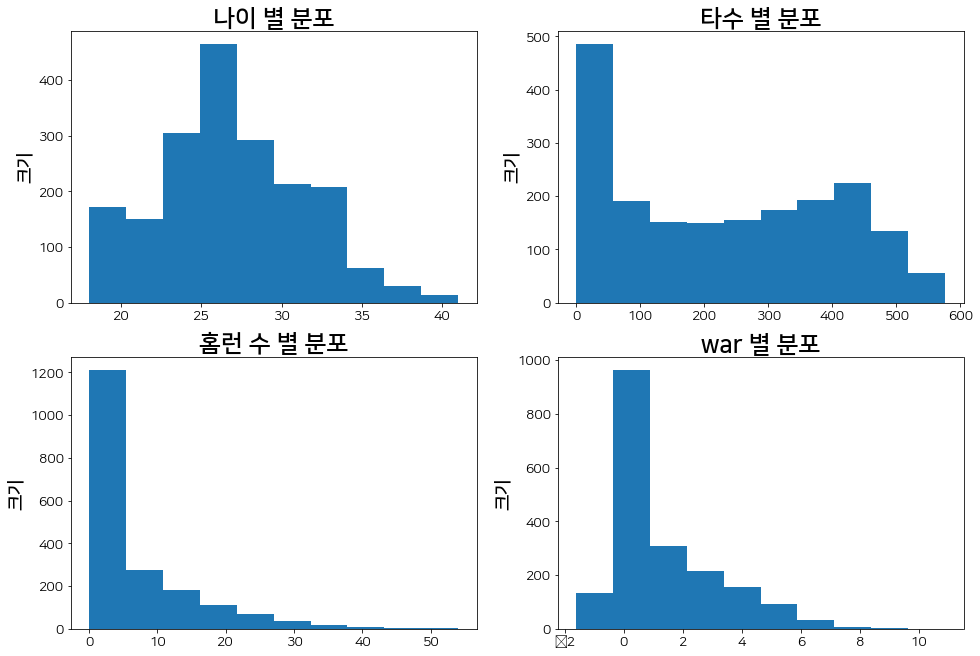

In [36]:
fig = plt.figure(figsize=(16,11))

plt.subplot(2,2,1)
plt.hist(regular_y2['age'])
plt.title('나이 별 분포',fontproperties=fp,size=title_font_size)
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.ylabel('크기',fontproperties=fp,size=label_font_size)

plt.subplot(2,2,2)
plt.hist(regular_y2['AB'])
plt.title('타수 별 분포',fontproperties=fp,size=title_font_size)
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.ylabel('크기',fontproperties=fp,size=label_font_size)

plt.subplot(2,2,3)
plt.hist(regular_y2['HR'])
plt.title('홈런 수 별 분포',fontproperties=fp,size=title_font_size)
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.ylabel('크기',fontproperties=fp,size=label_font_size)

plt.subplot(2,2,4)
plt.hist(regular_y2['war'])
plt.title('war 별 분포',fontproperties=fp,size=title_font_size)
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.ylabel('크기',fontproperties=fp,size=label_font_size);

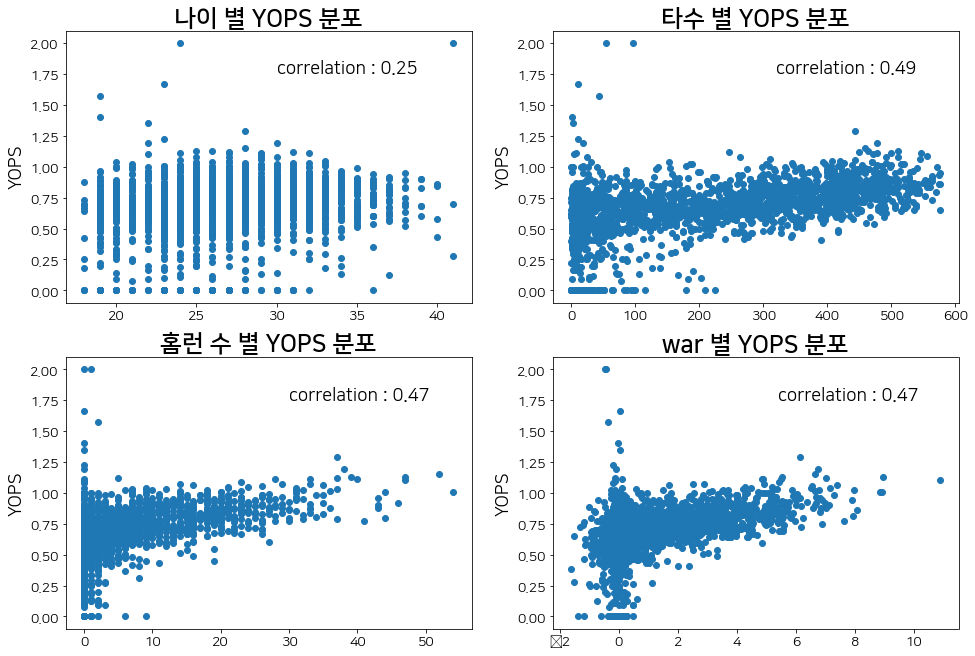

In [37]:
fig = plt.figure(figsize=(16,11))

plt.subplot(2,2,1)
plt.scatter(regular_y2['age'], regular_y2['YOPS'])
plt.title('나이 별 YOPS 분포',fontproperties=fp,size=title_font_size)
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.ylabel('YOPS',size=label_font_size)
plt.text(30,1.75,'correlation : 0.25',size=label_font_size)

plt.subplot(2,2,2)
plt.scatter(regular_y2['AB'], regular_y2['YOPS'])
plt.title('타수 별 YOPS 분포',fontproperties=fp,size=title_font_size)
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.ylabel('YOPS',size=label_font_size)
# plt.text(350,1.75,'correlation : 0.49',size=label_font_size)
plt.text(320,1.75,'correlation : 0.49',size=label_font_size)

plt.subplot(2,2,3)
plt.scatter(regular_y2['HR'], regular_y2['YOPS'])
plt.title('홈런 수 별 YOPS 분포',fontproperties=fp,size=title_font_size)
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.ylabel('YOPS',size=label_font_size)
plt.text(30,1.75,'correlation : 0.47',size=label_font_size)

plt.subplot(2,2,4)
plt.scatter(regular_y2['war'], regular_y2['YOPS'])
plt.title('war 별 YOPS 분포',fontproperties=fp,size=title_font_size)
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.ylabel('YOPS',size=label_font_size)
# plt.text(6,1.75,'correlation : 0.47',size=label_font_size);
plt.text(5.4,1.75,'correlation : 0.47',size=label_font_size);


## 4.3. Variation

In [38]:
#self correlation definition and scatter plot print 
def get_self_corr(var,data=regular_y):
    x=[]
    y=[]
    data_self_corr=data.loc[data['AB']>=50,]
    for name in data_self_corr['batter_name'].unique():
        a=data_self_corr.loc[data_self_corr['batter_name']==name,].sort_values('year')
        k=[]
        for i in a['year'].unique():
            if (a['year']==i+1).sum()==1:
                k.append(i)
        for i in k:
            x.append(a.loc[a['year']==i,var].iloc[0])
            y.append(a.loc[a['year']==i+1,var].iloc[0])
    plt.scatter(x,y)
    plt.title(var)
    
#self correlation definition and scatter plot print 
def get_self_corr_value(var,data=regular_y):
    x=[]
    y=[]
    data_self_corr=data.loc[data['AB']>=50,]
    for name in data_self_corr['batter_name'].unique():
        a=data_self_corr.loc[data_self_corr['batter_name']==name,].sort_values('year')
        k=[]
        for i in a['year'].unique():
            if (a['year']==i+1).sum()==1:
                k.append(i)
        for i in k:
            x.append(a.loc[a['year']==i,var].iloc[0])
            y.append(a.loc[a['year']==i+1,var].iloc[0])
    
    return (pd.Series(x).corr(pd.Series(y))**2)

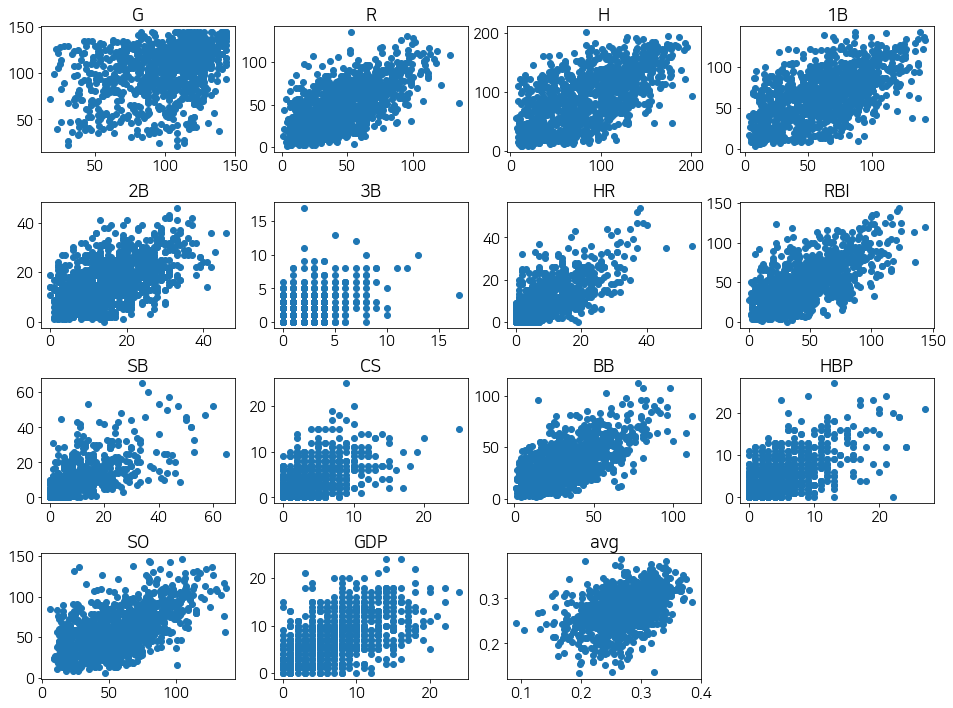

In [39]:
#subplot visualisation
plt.figure(figsize=(16,12))
plt.subplots_adjust(hspace=0.4)

plt.tight_layout()

plt.subplot(4,4,1)
get_self_corr('G')

plt.subplot(4,4,2)
get_self_corr('R')

plt.subplot(4,4,3)
get_self_corr('H')

plt.subplot(4,4,4)
get_self_corr('1B')

plt.subplot(4,4,5)
get_self_corr('2B')

plt.subplot(4,4,6)
get_self_corr('3B')

plt.subplot(4,4,7)
get_self_corr('HR')

plt.subplot(4,4,8)
get_self_corr('RBI')

plt.subplot(4,4,9)
get_self_corr('SB')

plt.subplot(4,4,10)
get_self_corr('CS')

plt.subplot(4,4,11)
get_self_corr('BB')

plt.subplot(4,4,12)
get_self_corr('HBP')

plt.subplot(4,4,13)
get_self_corr('SO')

plt.subplot(4,4,14)
get_self_corr('GDP')

plt.subplot(4,4,15)
get_self_corr('avg')

# plt.subplot(4,4,16)
# get_self_corr('E')

In [40]:
self_corr_value={}
for i in ['avg','G','R','H','1B','2B','3B','HR','RBI','SB','CS','BB','HBP','SO','GDP']:
    self_corr_value[i]=get_self_corr_value(i)
self_corr_value

{'avg': 0.18372902168036845,
 'G': 0.14635483118012918,
 'R': 0.394140091550835,
 'H': 0.3809099717300388,
 '1B': 0.3395708920415978,
 '2B': 0.31634923922835595,
 '3B': 0.21919436687859037,
 'HR': 0.5352567046571846,
 'RBI': 0.4459332055856541,
 'SB': 0.48664689420527835,
 'CS': 0.27283632112542583,
 'BB': 0.4415616600502027,
 'HBP': 0.3369213333346088,
 'SO': 0.3337929583835721,
 'GDP': 0.2928195368404539}

#### 상대적 신뢰성이 낮은 지표 (변동성이 높은 지표): **avg, GDP, G, 3B**  
#### 상대적 신뢰성이 높은 지표 (변동성이 낮은 지표): **BB, HR, RBI, SB**  

#### 신뢰성이 낮은 지표는 **운적인 요소가 강한** 지표라고 할수 있으며,  
#### 신뢰성이 높은 지표는 **운적인 요소가 적은** 지표라고 할수 있다.  

#### 이와같이 변동성이 높은 지표의 경우, 변동성을 줄이는 것이 요구된다.  

#### 따라서, 
#### 변동성이 높은 지표는 **선수의 누적성적 (Career_performance)** 로 변동성을 줄이는 것이 요구된다.

## 4.4. 변수 추가

### 4.4.1. 추가 도루횟수, eqa~babip 만들기

In [41]:
#도루 횟수 관련 변수 만들기
regular_y['run']=regular_y['SB']+regular_y['CS']

# eqa 구하기
eqa_high=regular_y['H']+regular_y['TB']+1.5*(regular_y['FBP'])+regular_y['run']  #eqa 분자 공식
eqa_low=regular_y['AB']+regular_y['FBP']+regular_y['CS']+(regular_y['run']/3) #eqa 분모 공식
regular_y['eqa']=round(eqa_high/eqa_low,3) #분자/분모
regular_y['eqa']=regular_y['eqa'].fillna(0) # NaN을 0으로 처리

# isop 구하기
regular_y['avg']=regular_y['avg'].replace('-',0.0) #현재 avg중에서 -처리가 된 것이 있어 0으로 대체함
regular_y['SLG']=regular_y['SLG'].fillna(0) # NaN을 0으로 처리
    
coerce_df_columns_to_numeric(regular_y,'avg') #문자로 인식이 되는 문제가 있어 숫자로 변경

regular_y['isop']=regular_y['SLG']-regular_y['avg'] #공식 사용
regular_y['isop']=round(regular_y['isop'],3) #보기 편하기 위해 소수3자리로 반올림

# 운 변수 투입하기
#데이콘 측에서 사용한 행운 변수 추가해보기
regular_y['1b_luck']=regular_y['1B']/(regular_y['AB']-regular_y['HR']-regular_y['SO'])
regular_y['2b_luck']=regular_y['2B']/(regular_y['AB']-regular_y['HR']-regular_y['SO'])
regular_y['3b_luck']=regular_y['3B']/(regular_y['AB']-regular_y['HR']-regular_y['SO'])

#심화적인 변수들중 BB%,SO%가 쓰이는 경우가 있다.

regular_y['BB%']=regular_y['BB']/regular_y['PA']
regular_y['BB%']=regular_y['BB%'].fillna(0.0)
regular_y['BB%']=round(regular_y['BB%'],3)

regular_y['SO%']=regular_y['SO']/regular_y['PA']

#BABIP구하기
regular_y['babip']= round( (regular_y['H']-regular_y['HR']) / (regular_y['AB']-regular_y['SO']-regular_y['HR']+regular_y['fly']) ,3)
regular_y['babip']=regular_y['babip'].fillna(0) # NaN을 0으로 처리

### 4.4.2 심화 변수들 생성

#### SPD 구하기 

타자의 속도와 관련된 변수로 spd는 5개의 척도들의 평균을 이용한 값으로 

f1은 도루성공 관련, f2는 도루관련 f3은 홈런제외 타구비율
f4는 3루타 비율 f5는 병살관련 부분이다.

In [42]:
agg={}
for i in range(2006,2019,1):

    regular3=regular_y[ (regular_y['year']==i) & (regular_y['AB']>=100) ]
    regular3=regular3.reset_index(drop=True)

    #인원수를 동일하게 맞춰줘야 되기 때문에 f1 ~f5를 다시 생성하였음

    f1= DataFrame( [( ((regular3['SB'][i]+3) / (regular3['SB'][i]+regular3['CS'][i]+7)) -0.4) * 20 for i in range(len(regular3)) ] ,columns=['f1'])
    f2=DataFrame( [ (math.sqrt( (regular3['SB'][i]+regular3['CS'][i])/ ( (regular3['H'][i]-regular3['2B'][i]-regular3['3B'][i]-regular3['HR'][i]) +regular3['BB'][i]+regular3['HBP'][i]) )) /0.07 for i in range(len(regular3)) ] ,columns=['f2'])
    f3= DataFrame( [ (regular3['3B'][i]/(regular3['AB'][i]-regular3['HR'][i]-regular3['SO'][i]))*625 for i in range(len(regular3)) ] ,columns=['f3'])
    f4= DataFrame( [ (((regular3['R'][i]-regular3['HR'][i])/(regular3['H'][i]+regular3['BB'][i]-regular3['HR'][i]+regular3['HBP'][i]))-0.1)*25 for i in range(len(regular3)) ] ,columns=['f4'])
    f5= DataFrame( [ (0.063-(regular3['GDP'][i]/(regular3['AB'][i]-regular3['HR'][i]-regular3['SO'][i])))/0.007 for i in range(len(regular3)) ] ,columns=['f5'])

    f_total=pd.concat([f1,f2,f3,f4,f5],axis=1)

    scaler = MinMaxScaler()
    scaler.fit(f_total)

    f_total2=DataFrame(scaler.transform(f_total)*10)

    f_total3=pd.concat([regular3[['batter_name','year']],f_total2 ],axis=1)
    f_total3=f_total3.fillna(0) #비어있는 부분을 0으로 채움

    f_total3['spd'] = (f_total3[0]+f_total3[1]+f_total3[2]+f_total3[3]+f_total3[4])/5
    agg[i-2006]=f_total3[['batter_name','year','spd']]

In [43]:
regular3=regular_y[ (regular_y['year']<=2005) & (regular_y['AB']>=100) ]
regular3=regular3.reset_index(drop=True)

#인원수를 동일하게 맞춰줘야 되기 때문에 f1 ~f5를 다시 생성하였음

f1= DataFrame( [( ((regular3['SB'][i]+3) / (regular3['SB'][i]+regular3['CS'][i]+7)) -0.4) * 20 for i in range(len(regular3)) ] ,columns=['f1'])
f2=DataFrame( [ (math.sqrt( (regular3['SB'][i]+regular3['CS'][i])/ ( (regular3['H'][i]-regular3['2B'][i]-regular3['3B'][i]-regular3['HR'][i]) +regular3['BB'][i]+regular3['HBP'][i]) )) /0.07 for i in range(len(regular3)) ] ,columns=['f2'])
f3= DataFrame( [ (regular3['3B'][i]/(regular3['AB'][i]-regular3['HR'][i]-regular3['SO'][i]))*625 for i in range(len(regular3)) ] ,columns=['f3'])
f4= DataFrame( [ (((regular3['R'][i]-regular3['HR'][i])/(regular3['H'][i]+regular3['BB'][i]-regular3['HR'][i]+regular3['HBP'][i]))-0.1)*25 for i in range(len(regular3)) ] ,columns=['f4'])
f5= DataFrame( [ (0.063-(regular3['GDP'][i]/(regular3['AB'][i]-regular3['HR'][i]-regular3['SO'][i])))/0.007 for i in range(len(regular3)) ] ,columns=['f5'])

f_total=pd.concat([f1,f2,f3,f4,f5],axis=1)

scaler = MinMaxScaler()
scaler.fit(f_total)

f_total2=DataFrame(scaler.transform(f_total)*10)

f_total3=pd.concat([regular3[['batter_name','year']],f_total2 ],axis=1)
f_total3=f_total3.fillna(0) #비어있는 부분을 0으로 채움

f_total3['spd'] = (f_total3[0]+f_total3[1]+f_total3[2]+f_total3[3]+f_total3[4])/5
agg[13]=f_total3[['batter_name','year','spd']]

In [44]:
f_real=pd.concat(agg,ignore_index=True)
f_real=f_real.drop_duplicates(keep='first')

regular_y3=pd.merge(regular_y,f_real,how='left',on=['batter_name','year'])

# regular_y3.to_csv("regular3.csv",index=False)

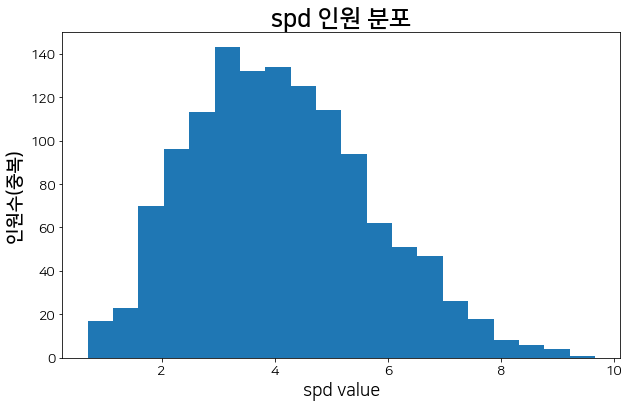

In [45]:
#변화되는 공식이 아닌 일반적인 공식을 사용하였음
# regular_y3['spd'].hist(bins=20,figsize=(20,10)) #확인 필요
regular_y3['spd'].hist(bins=20,figsize=figure_size) #확인 필요
plt.grid(False)
plt.xticks(size=tick_label_font_size)
plt.yticks(size=tick_label_font_size)
plt.xlabel('spd value',size=label_font_size)
plt.ylabel('인원수(중복) ',fontproperties=fp,size=label_font_size)
plt.title('spd 인원 분포',fontproperties=fp,size=title_font_size);

In [46]:
regular_y3['spd']=regular_y3['spd'].fillna(regular_y3['spd'].mean())

#### wOBA구하기

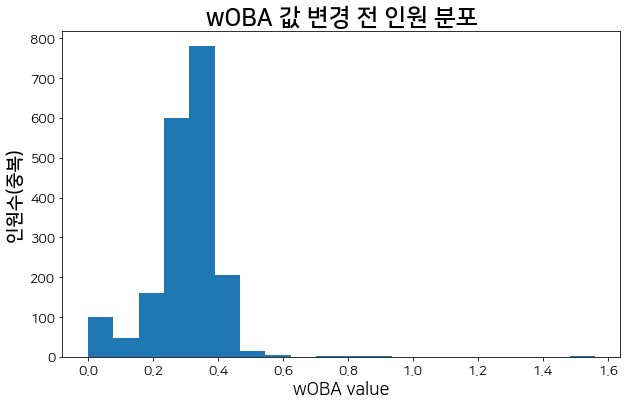

In [47]:
#변화되는 공식이 아닌 일반적인 공식을 사용하였음
regular_y3['wOBA']=(0.72*regular_y3['BB'] + 0.75*regular_y3['HBP'] + 0.9*regular_y3['1B'] + 1.24*regular_y3['2B'] + 1.56*regular_y3['3B'] + 1.95*regular_y3['HR'] ) / ( regular_y3['AB'] +regular_y3['FBP'] + regular_y3['fly'] )
regular_y3['wOBA']=regular_y3['wOBA'].fillna(0.0) 

regular_y3['wOBA']=round(regular_y3['wOBA'],3)

# regular_y3['wOBA'].hist(bins=20,figsize=(20,10)) #확인 필요
regular_y3['wOBA'].hist(bins=20,figsize=figure_size) #확인 필요
plt.grid(False)
plt.xticks(size=tick_label_font_size)
plt.yticks(size=tick_label_font_size)
plt.xlabel('wOBA value',size=label_font_size)
plt.ylabel('인원수(중복) ',fontproperties=fp,size=label_font_size)
plt.title('wOBA 값 변경 전 인원 분포',fontproperties=fp,size=title_font_size);

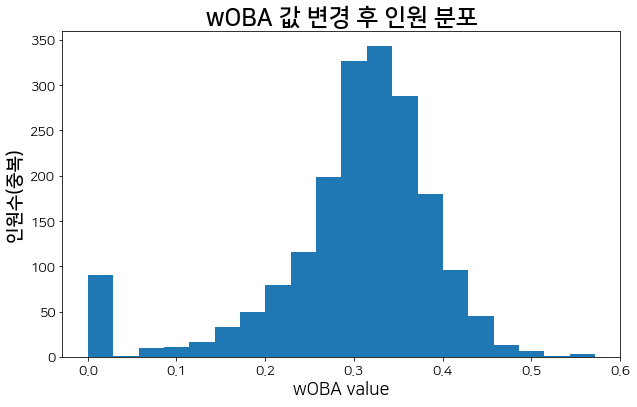

In [48]:
#변화되는 공식이 아닌 일반적인 공식을 사용하였음
regular_y3['wOBA']=(0.72*regular_y3['BB'] + 0.75*regular_y3['HBP'] + 0.9*regular_y3['1B'] + 1.24*regular_y3['2B'] + 1.56*regular_y3['3B'] + 1.95*regular_y3['HR'] ) / ( regular_y3['AB'] +regular_y3['FBP'] + regular_y3['fly'] )
regular_y3['wOBA']=regular_y3['wOBA'].fillna(0.0) 

regular_y3['wOBA']=round(regular_y3['wOBA'],3)
regular_y33=regular_y3.loc[regular_y3['wOBA']<0.6]

# regular_y33['wOBA'].hist(bins=20,figsize=(20,10)) #확인 필요
regular_y33['wOBA'].hist(bins=20,figsize=figure_size) #확인 필요
plt.grid(False)
plt.xticks(size=tick_label_font_size)
plt.yticks(size=tick_label_font_size)
plt.xlabel('wOBA value',size=label_font_size)
plt.ylabel('인원수(중복) ',fontproperties=fp,size=label_font_size)
plt.title('wOBA 값 변경 후 인원 분포',fontproperties=fp,size=title_font_size);

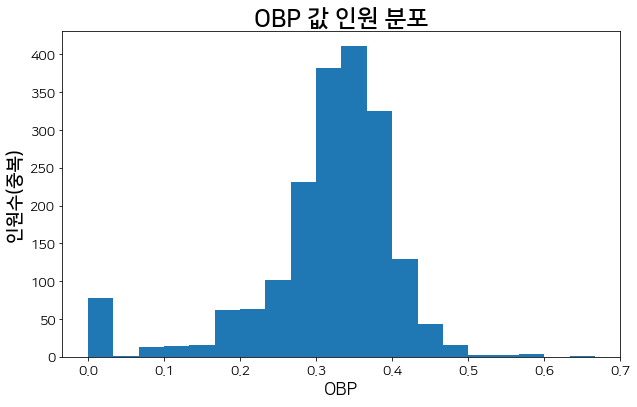

In [49]:
# regular_y33['OBP'].hist(bins=20,figsize=(20,10)) #확인 필요
regular_y33['OBP'].hist(bins=20,figsize=figure_size) #확인 필요
plt.grid(False)
plt.xticks(size=tick_label_font_size)
plt.yticks(size=tick_label_font_size)
plt.xlabel('OBP',size=label_font_size)
plt.ylabel('인원수(중복) ',fontproperties=fp,size=label_font_size)
plt.title('OBP 값 인원 분포',fontproperties=fp,size=title_font_size);

#### OPS+구하기

In [50]:
#각 시즌별 평균 값이 필요하기 때문에 해당 과정을 실시
mra=regular_y3.groupby(['year'])['wOBA', 'R','H','FBP', 'AB', 'fly', 'TB'].sum()
mra2=regular_y3.groupby(['year'])['wOBA', 'R','H','FBP', 'AB', 'fly', 'TB'].size()
mra['size']=mra2

mra.to_csv("mra.csv")
mra=pd.read_csv("mra.csv")

In [51]:
# mra #현재 2000년대 연도들은 사이즈가 너무 작아서 평균을 구하는게 힘들어 보임
# #그래서 몇개 연도를 합쳐서 그 평균값을 사용하기로 결정함(2004년이전, 2005~2006 통합)

In [52]:
#2003년 이전 합치기
mra.loc[mra['year']<=2003,'wOBA']=(mra.loc[mra['year']<=2003,'wOBA'].sum()) 
mra.loc[mra['year']<=2003,'R']=(mra.loc[mra['year']<=2003,'R'].sum()) 
mra.loc[mra['year']<=2003,'H']=(mra.loc[mra['year']<=2003,'H'].sum()) 
mra.loc[mra['year']<=2003,'FBP']=(mra.loc[mra['year']<=2003,'FBP'].sum()) 
mra.loc[mra['year']<=2003,'AB']=(mra.loc[mra['year']<=2003,'AB'].sum()) 
mra.loc[mra['year']<=2003,'fly']=(mra.loc[mra['year']<=2003,'fly'].sum()) 
mra.loc[mra['year']<=2003,'TB']=(mra.loc[mra['year']<=2003,'TB'].sum()) 
mra.loc[mra['year']<=2003,'size']=(mra.loc[mra['year']<=2003,'size'].sum()) 

#2004년과 2005년 합치기

mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'wOBA']= (mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'wOBA'].sum()) 
mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'R']=(mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'R'].sum()) 
mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'H']=(mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'H'].sum()) 
mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'FBP']=(mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'FBP'].sum()) 
mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'AB']=(mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'AB'].sum()) 
mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'fly']=(mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'fly'].sum())
mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'TB']=(mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'TB'].sum()) 
mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'size']=(mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'size'].sum()) 

#2006 2007
mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'wOBA']= (mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'wOBA'].sum()) 
mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'R']=(mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'R'].sum()) 
mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'H']=(mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'H'].sum()) 
mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'FBP']=(mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'FBP'].sum()) 
mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'AB']=(mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'AB'].sum()) 
mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'fly']=(mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'fly'].sum())
mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'TB']=(mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'TB'].sum()) 
mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'size']=(mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'size'].sum()) 

#2008 2009
mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'wOBA']= (mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'wOBA'].sum()) 
mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'R']=(mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'R'].sum()) 
mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'H']=(mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'H'].sum()) 
mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'FBP']=(mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'FBP'].sum()) 
mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'AB']=(mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'AB'].sum()) 
mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'fly']=(mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'fly'].sum())
mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'TB']=(mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'TB'].sum()) 
mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'size']=(mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'size'].sum()) 

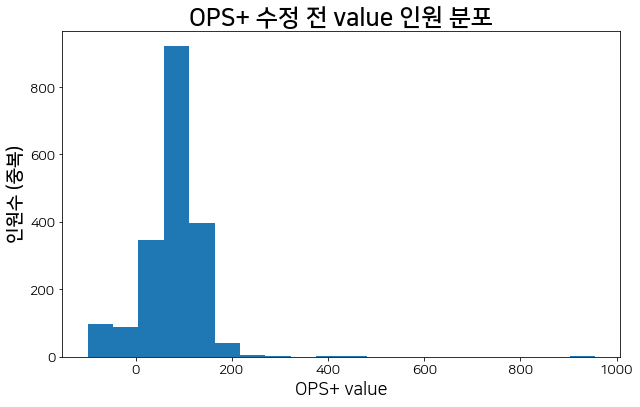

In [53]:
mra['aOBP']=(mra['H']+mra['FBP'])/(mra['AB']+mra['FBP']+mra['fly']) #각 연도의 평균 OBP생성

mra['aSLG']=mra['TB']/mra['AB'] #각 연도의 평균 SLG생성

mra_total=mra[['year','aOBP','aSLG']] #각 연도별 평균 OBP,SLG만 추출

regular4=pd.merge(regular_y3,mra_total,how='left') #각 선수별 OPS+를 적용시키기 위해서 통합 실시

#OPS + 를 구하는 공식을 사용하고 OPS+는 자연수 값이기 때문에 반올림로 정수 처리하였음
regular4['OPS+']= ( (regular4['OBP']/regular4['aOBP']) + (regular4['SLG']/regular4['aSLG']) -1 ) * 100
regular4['OPS+']=round(regular4['OPS+'],0)

# regular4['OPS+'].hist(bins=20,figsize=(20,10)) #현재 0이하의 값과 200이상의 이상치들이 보이는 모습이 있음
regular4['OPS+'].hist(bins=20,figsize=figure_size) #현재 0이하의 값과 200이상의 이상치들이 보이는 모습이 있음
plt.grid(False)
plt.xticks(size=tick_label_font_size)
plt.yticks(size=tick_label_font_size)
plt.xlabel('OPS+ value',size=label_font_size)
plt.ylabel('인원수 (중복)',fontproperties=fp,size=label_font_size)
plt.title('OPS+ 수정 전 value 인원 분포',fontproperties=fp,size=title_font_size);

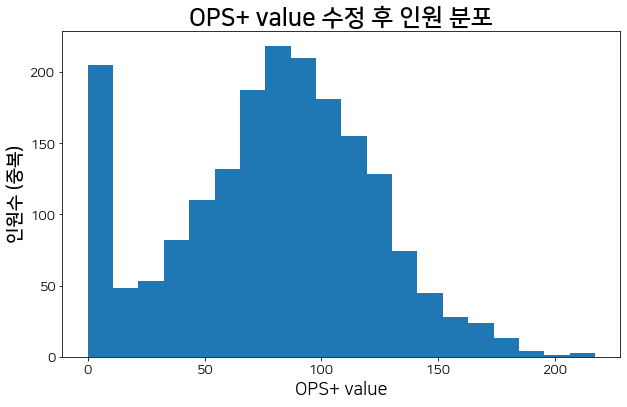

In [54]:
regular4.loc[regular4['OPS+']>=220,['OPS+']]=0 #200이상의 이상치는 0으로 처리
regular4.loc[regular4['OPS+']<=0,['OPS+']]=0 #0이하의 값은 0으로 처리

#다 사용이 된 평균 OBP,SLG는 삭제함
del regular4['aOBP']
del regular4['aSLG']

# regular4['OPS+'].hist(bins=20,figsize=(20,10)) #이상치 제거 이후 OPS+확인 작업
regular4['OPS+'].hist(bins=20,figsize=figure_size) #이상치 제거 이후 OPS+확인 작업
plt.grid(False)
plt.xticks(size=tick_label_font_size)
plt.yticks(size=tick_label_font_size)
plt.xlabel('OPS+ value',size=label_font_size)
plt.ylabel('인원수 (중복)',fontproperties=fp,size=label_font_size)
plt.title('OPS+ value 수정 후 인원 분포',fontproperties=fp,size=title_font_size);

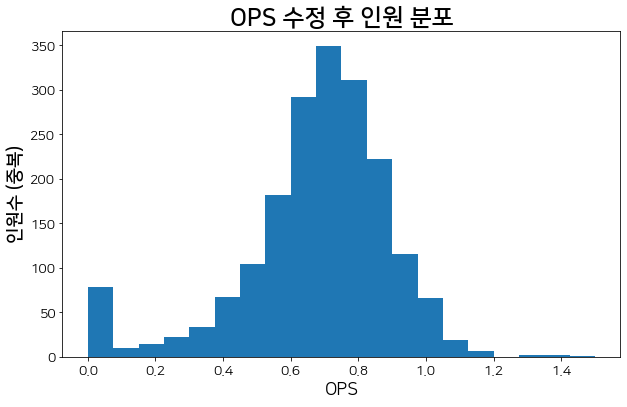

In [55]:
regular555=regular4[regular4['OPS']<=1.5]
# regular555['OPS'].hist(bins=20,figsize=(20,10)) #이상치 제거 이후 OPS+확인 작업
regular555['OPS'].hist(bins=20,figsize=figure_size) #이상치 제거 이후 OPS+확인 작업
plt.grid(False)
plt.xticks(size=tick_label_font_size)
plt.yticks(size=tick_label_font_size)
plt.xlabel('OPS',size=label_font_size)
plt.ylabel('인원수 (중복)',fontproperties=fp,size=label_font_size)
plt.title('OPS 수정 후 인원 분포',fontproperties=fp,size=title_font_size);

### 4.4.3 선수당 시즌 보낸 횟수

In [56]:
regular46=regular4.copy()
regular46=regular46.sort_values(by=['batter_name', 'year']) #이름과 연도 별로 sort

tk=[i for i in regular46['batter_name'][1:]] #각 관측치마다 연차를 부여하기 위해서 생성
tk2=[i for i in regular46['batter_name'][0:]]

co=list() #해당 관측치와 다음 관측치의 이름이 같으면 1년차 -> 2년차의 방식을 빠르게 수행하기 위해서 시행
co.append(1)
for i in range(len(tk)):
    if tk[i]==tk2[i]:
        co.append(co[i]+1)
    else:
        co.append(1)
regular46['work_year']=co

regular46=regular46.sort_index()

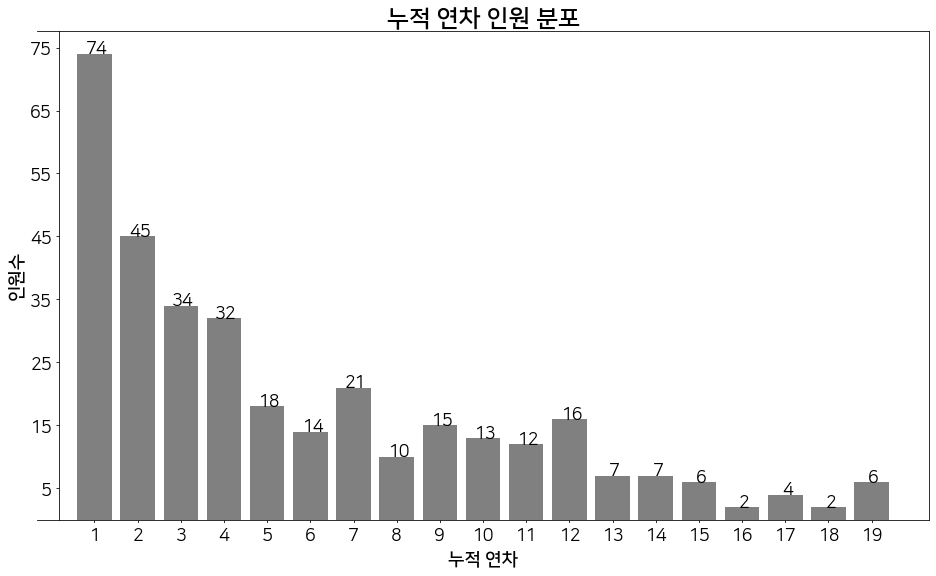

In [57]:
regular6=regular46[['batter_name','work_year']]

regular6=regular6.drop_duplicates(keep='first')

c=Counter(Counter(regular6['batter_name']).values()) #이름 갯수로 누적 시즌 횟수 획득
x3=[]
y3=[]
for i in range(len(c)):
    x3.append(sorted(c.items(), key=itemgetter(0))[i][0]) # 1~ 17
    y3.append(sorted(c.items(), key=itemgetter(0))[i][1]) # 해당 시즌 보낸 사람 인원수

# f,ax=plt.subplots(figsize=(20,9))
f,ax=plt.subplots(figsize=(16,9))

plt.bar(x3,y3,color='grey')
plt.xticks(x3, (list(range(1,20))),size=tick_label_font_size)
plt.yticks(range(5,80,10),size=tick_label_font_size)
plt.xlabel('누적 연차',fontproperties=fp,size=label_font_size)
plt.ylabel('인원수',fontproperties=fp,size=label_font_size)
ax.spines['left'].set_position(('axes', 0.025))
plt.title('누적 연차 인원 분포',fontproperties=fp,size=title_font_size)

#ax.spines를 한 이후 축 글자 크기 변경시 사용한 부분
for label in ax.get_xticklabels() + ax.get_yticklabels(): 
    label.set_fontsize(label_font_size)
#     label.set_bbox(dict(facecolor='white', edgecolor='None', alpha=0.65 ))
    label.set_bbox(dict(facecolor='white', edgecolor='None'))
    
for x,y in zip(range(1,20),y3):
    if y>=10:
        plt.text(x-0.2,y,y3[x-1],size=label_font_size)
    else:
        plt.text(x-0.075,y,y3[x-1],size=label_font_size)
        
regular46.to_csv("regular_total.csv",index=False)

### 4.4.4 공 반발계수 추가하기

In [58]:
total=pd.read_csv("regular_total.csv")
# total=regular46.copy()
total['ball_score']=0.45032

total['ball_score'] = [np.where( total['year'][i]==2009, np.random.normal(0.4297, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2010, np.random.normal(0.4187, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2011, np.random.normal(0.4228, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2012, np.random.normal(0.4172, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2013, np.random.normal(0.4236, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2014, np.random.normal(0.4316, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2015, np.random.normal(0.4244, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2016, np.random.normal(0.4216, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2017, np.random.normal(0.4224, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2018, np.random.normal(0.4187, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]

total['ball_score'] = [np.where( (total['year'][i]<2009) | (total['year'][i]>2018) , np.random.normal(0.42307, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]

In [59]:
total['p_year']=total['year']+1
total['next_ball_score']=0.45032

total['next_ball_score'] = [np.where( total['p_year'][i]<2009, np.random.normal(0.42307, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2009, np.random.normal(0.4297, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2010, np.random.normal(0.4187, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2011, np.random.normal(0.4228, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2012, np.random.normal(0.4172, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2013, np.random.normal(0.4236, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2014, np.random.normal(0.4316, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2015, np.random.normal(0.4244, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2016, np.random.normal(0.4216, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2017, np.random.normal(0.4224, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2018, np.random.normal(0.4187, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2019, np.random.normal(0.41, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]

In [60]:
coerce_df_columns_to_numeric(total,'ball_score') #문자로 입력된 것을 숫자로 변경
coerce_df_columns_to_numeric(total,'next_ball_score') #문자로 입력된 것을 숫자로 변경
cor1=total[['ball_score','next_ball_score','YOPS']].corr()
cor1

,ball_score,next_ball_score,YOPS
ball_score,1.000000,0.142295,0.015874
next_ball_score,0.142295,1.000000,0.016267
YOPS,0.015874,0.016267,1.000000


In [61]:
cor1['ball_score']['YOPS']

0.015874197773902202

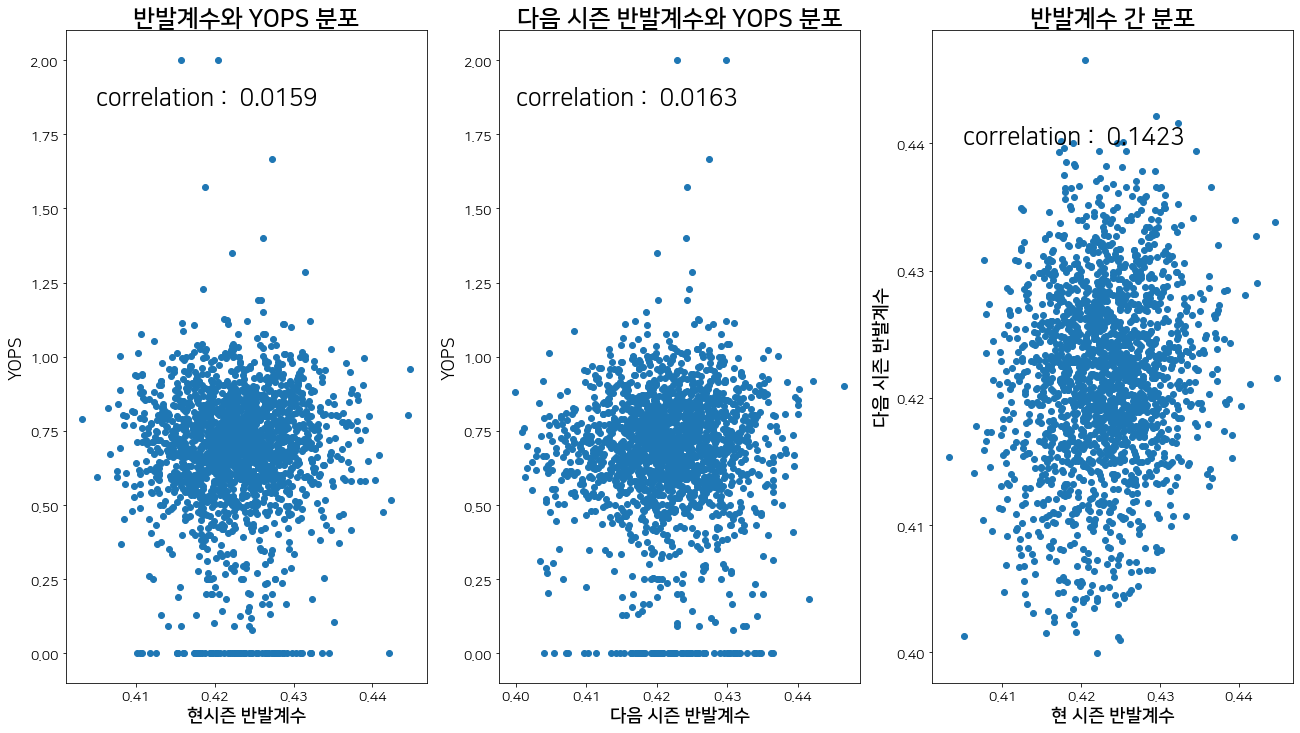

In [62]:
fig = plt.figure(figsize=(22,12))

plt.subplot(1,3,1)
plt.scatter(total['ball_score'], total['YOPS'])
plt.title('반발계수와 YOPS 분포',fontproperties=fp,size=title_font_size)
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.xlabel('현시즌 반발계수',fontproperties=fp,size=label_font_size)
plt.ylabel('YOPS',size=label_font_size)
plt.text(0.405,1.85, 'correlation :  ' + str(round(cor1['ball_score']['YOPS'],4)) ,size=title_font_size)

plt.subplot(1,3,2)
plt.scatter(total['next_ball_score'], total['YOPS'])
plt.title('다음 시즌 반발계수와 YOPS 분포',fontproperties=fp,size=title_font_size)
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.xlabel('다음 시즌 반발계수',fontproperties=fp,size=label_font_size)
plt.ylabel('YOPS',size=label_font_size)
plt.text(0.4,1.85,'correlation :  ' + str(round(cor1['next_ball_score']['YOPS'],4)),size=title_font_size)

plt.subplot(1,3,3)
plt.scatter(total['ball_score'], total['next_ball_score'])
plt.title('반발계수 간 분포',fontproperties=fp,size=title_font_size)
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.xlabel('현 시즌 반발계수',fontproperties=fp,size=label_font_size)
plt.ylabel('다음 시즌 반발계수',fontproperties=fp,size=label_font_size)
# plt.text(0.40,0.445, 'correlation :  ' + str(round(cor1['ball_score']['next_ball_score'],4)) ,size=title_font_size);
plt.text(0.405,0.44, 'correlation :  ' + str(round(cor1['ball_score']['next_ball_score'],4)) ,size=title_font_size);

total.to_csv("real_total.csv",index=False)

# 5. 모델링

## 5.1. train, test 나누기 및 변수 선택

### 불필요한 변수 제거

In [63]:
# total=pd.read_csv("real_total.csv")

del total['BB']
del total['HBP']

del total['PA']

del total['SB']
del total['CS']

del total['OBP']
del total['SLG']

del total['1B']
del total['2B']
del total['3B']

del total['SO']

In [64]:
train=total.copy()
del train['p_year']

train_y2=train[['year','YAB','YOPS']]

y_train=train_y2[train_y2['year']<=2017].reset_index(drop=True)
y_test=train_y2[train_y2['year']==2018].reset_index(drop=True)

del y_train['year']
del y_test['year']

del train['batter_name']
del train['YAB']
del train['YOPS']

train = pd.get_dummies(train,columns=['hand2'])
train = pd.get_dummies(train,columns=['tp'])

X_train=train[train['year']<=2017].reset_index(drop=True)

X_test=train[train['year']==2018].reset_index(drop=True)

del X_train['year']
del X_test['year']

In [65]:
X_train=X_train.fillna(0.0000)

X_test=X_test.fillna(0.0000)

y_train=y_train.fillna(0.0000)

y_test=y_test.fillna(0.0000)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1718, 38), (195, 38), (1718, 2), (195, 2))

### eda 제거

In [66]:
list1=list(X_train[X_train['OPS']>=1.25].index)
X_train=X_train.drop(list1,axis=0).reset_index(drop=True)
y_train=y_train.drop(list1,axis=0).reset_index(drop=True)

list2=list(X_train[X_train['OPS+']<=25].index)
X_train=X_train.drop(list2,axis=0).reset_index(drop=True)
y_train=y_train.drop(list2,axis=0).reset_index(drop=True)

# list3=list(X_train[ (X_train['AB']<=10) & (X_train['OPS']>=1) ].index)
# X_train=X_train.drop(list3,axis=0).reset_index(drop=True)
# y_train=y_train.drop(list3,axis=0).reset_index(drop=True)

# list4=list(X_train[ (X_train['AB']<=10) & (X_train['OPS']<=0.00001) ].index)
# X_train=X_train.drop(list4,axis=0).reset_index(drop=True)
# y_train=y_train.drop(list4,axis=0).reset_index(drop=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1460, 38), (195, 38), (1460, 2), (195, 2))

## 5.2. randomforestregressor

### grid_search로 최적의 하이퍼파라미터 결정

In [67]:
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'max_features': [2, 3],
#     'min_samples_leaf': [7,9,11],
#     'min_samples_split': [2,3],
#     'n_estimators': [200,300,500]
# }
# # Create a based model
# rf = RandomForestRegressor(criterion='mae',random_state=1234)
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid)

# grid_search.fit(X_train, y_train['YOPS'])

In [68]:
# grid_search.best_params_

In [69]:
# best_grid = grid_search.best_estimator_

### train 결측치 제거 추가적인 eda도 한 경우

In [70]:
# best_grid = RandomForestRegressor(criterion='mae',max_features=3,min_samples_leaf=7, min_samples_split=2, n_estimators=200,random_state=1234)
best_grid = RandomForestRegressor(criterion='mae',max_features=3,min_samples_leaf=7, min_samples_split=2, n_estimators=300,random_state=1234)

best_grid.fit(X_train,y_train['YOPS'])

RandomForestRegressor(criterion='mae', max_features=3, min_samples_leaf=7,
                      n_estimators=300, random_state=1234)

In [71]:
y_pred_train = best_grid.predict(X_train)

print( 'train randomforest regressor mae :' , round(mean_absolute_error(y_train['YOPS'], y_pred_train),4) )

train randomforest regressor mae : 0.0895


In [72]:
y_pred = best_grid.predict(X_test)

print( 'test randomforest regressor mae :' , round(mean_absolute_error(y_test['YOPS'], y_pred),4) )

test randomforest regressor mae : 0.1226


In [73]:
print( 'test randomforest regressor 가중치 rmse :' , round( sqrt( (( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()) ),4) )

test randomforest regressor 가중치 rmse : 0.1036


In [74]:
df1 = DataFrame( list(zip(y_test['YOPS'],y_pred,y_test['YAB'])), columns=['YOPS','predict','YAB']  )

df1 = df1[df1['YAB']>=50]

print( '50타수 이상 test randomforest regressor mae :' , round( mean_absolute_error(df1['YOPS'], df1['predict']),4) )

50타수 이상 test randomforest regressor mae : 0.0898


In [75]:
print( '50타수 이상 test randomforest regressor 가중치 rmse :' , round( sqrt( (( (((df1['YOPS']-df1['predict'])**2)*df1['YAB']).sum() )  /  df1['YAB'].sum()) ),4) )

50타수 이상 test randomforest regressor 가중치 rmse : 0.1006


# 6. 최종 결론

## 6.1 변수 중요도 파악하기

In [76]:
n_feature = X_train.shape[1] #주어진 변수들의 갯수를 구함
index = np.arange(n_feature)
input_var=X_train.columns

#### 학습된 rf에서 feature_importance_를 입력하면, 해당 변수에 대한 변수 중요도가 수치적으로 나타난다.  이를 수평 막대 그래프를 활용하여 그리는 과정은 다음과 같다.

In [77]:
score2=DataFrame( list(zip(input_var,best_grid.feature_importances_  )), columns=['name','importance'])
score2=score2.sort_values('importance')
score3=score2.sort_values('importance',ascending=False)

In [78]:
score3.head(6)

,name,importance
6,TB,0.065074
27,wOBA,0.059357
7,RBI,0.058436
16,OPS,0.056821
18,eqa,0.053652
5,HR,0.053193


In [79]:
score3.tail(6)

,name,importance
33,hand2_우타,0.003913
36,tp_외야수,0.003641
34,hand2_좌타,0.003516
35,tp_내야수,0.002779
37,tp_포수,0.002234
32,hand2_양타,0.000081


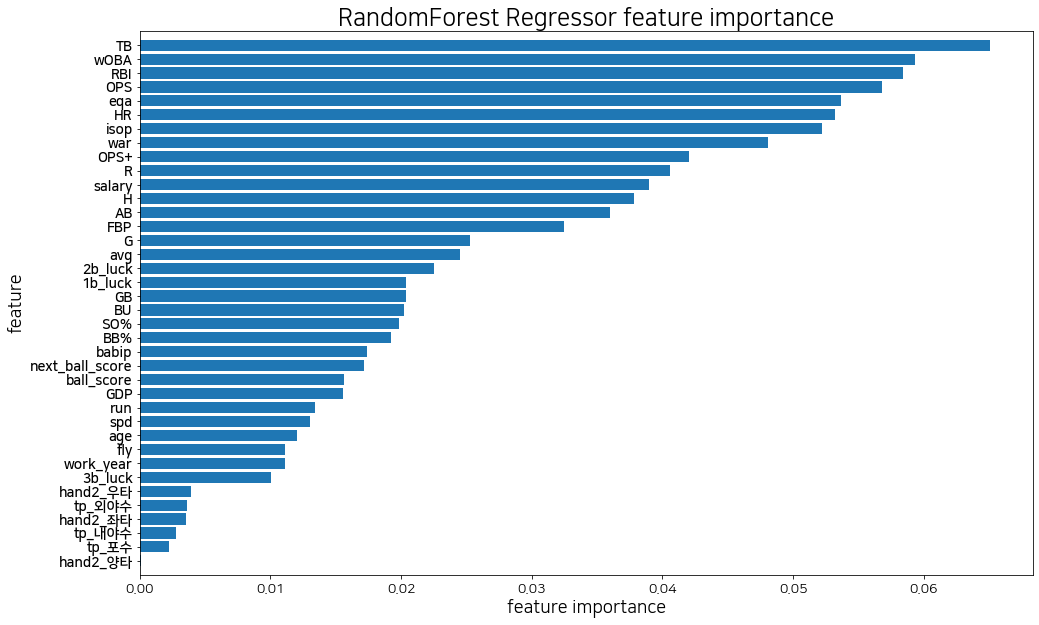

In [80]:
plt.rcParams["figure.figsize"] = (16,10)

plt.barh(index, score2['importance'], align='center') #
plt.xticks(size=tick_label_font_size)
plt.yticks(index, score2['name'],fontproperties=fp,size=tick_label_font_size)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=label_font_size)
plt.ylabel('feature', size=label_font_size)
plt.title('RandomForest Regressor feature importance', size=title_font_size)
plt.show();

## 6.2. xgbregressor, lin_reg OPS예측 비교

### xgbregressor

In [81]:
est=XGBRegressor(max_depth=3, learning_rate=0.005, n_estimators=100,
                     objective='reg:linear', booster='gblinear', reg_lambda=1,
                     scale_pos_weight=190, base_score=0.4, random_state=0,
                     seed=None, missing=None)

result=est.fit(X_train, y_train['YOPS'], sample_weight=None, eval_set=None, eval_metric=None,
                  early_stopping_rounds=None, verbose=True, xgb_model=None)



[03:05:42] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[03:05:42] WARNING: ../src/learner.cc:573: 
Parameters: { "max_depth" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [82]:
y_pred_train = result.predict(X_train)

print( 'train randomforest regressor mae :' , round(mean_absolute_error(y_train['YOPS'], y_pred_train),4) )

xg1 = round(mean_absolute_error(y_train['YOPS'], y_pred_train),4)

train randomforest regressor mae : 0.1152


In [83]:
y_pred = result.predict(X_test)

print( 'test randomforest regressor mae :' , round(mean_absolute_error(y_test['YOPS'], y_pred),4) )

xg2 = round(mean_absolute_error(y_test['YOPS'], y_pred),4)

test randomforest regressor mae : 0.1395


In [84]:
print( 'test randomforest regressor 가중치 rmse :' ,round( sqrt( (( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()) ),4) )

xg3 = round( sqrt( (( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()) ),4)

test randomforest regressor 가중치 rmse : 0.1278


In [85]:
df1 = DataFrame( list(zip(y_test['YOPS'],y_pred,y_test['YAB'])), columns=['YOPS','predict','YAB']  )

df1 = df1[df1['YAB']>=50]

print( '50타수 이상 test randomforest regressor mae :' , round(mean_absolute_error(df1['YOPS'], df1['predict']),4) )

xg4 = round(mean_absolute_error(df1['YOPS'], df1['predict']),4)

50타수 이상 test randomforest regressor mae : 0.1089


### linear regression

In [86]:
model2 = LinearRegression().fit(X_train, y_train['YOPS'])

y_pred_train = model2.predict(X_train)

print( 'train randomforest regressor mae :' , round(mean_absolute_error(y_train['YOPS'], y_pred_train),4) )

lin1 =  round(mean_absolute_error(y_train['YOPS'], y_pred_train),4)

train randomforest regressor mae : 0.1077


In [87]:
y_pred = model2.predict(X_test)

print( 'test randomforest regressor mae :' , round(mean_absolute_error(y_test['YOPS'], y_pred),4) )

lin2 =  round(mean_absolute_error(y_test['YOPS'], y_pred),4)

test randomforest regressor mae : 0.1393


In [88]:
print( 'test randomforest regressor 가중치 rmse :' ,round( sqrt( (( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()) ),4) )

lin3 =  round( sqrt( (( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()) ),4)


test randomforest regressor 가중치 rmse : 0.1335


In [89]:
df1 = DataFrame( list(zip(y_test['YOPS'],y_pred,y_test['YAB'])), columns=['YOPS','predict','YAB']  )

df1 = df1[df1['YAB']>=50]

print( '50타수 이상 test randomforest regressor mae :' , round(mean_absolute_error(df1['YOPS'], df1['predict']),4) )

lin4 =  round(mean_absolute_error(df1['YOPS'], df1['predict']),4)

50타수 이상 test randomforest regressor mae : 0.108


### xgbregressor 와 linear regression  OPS 예측치와 실제값의 차이

In [90]:
data = {'regressor': ['xgbregressor', 'linear regression'], 'train mae': [xg1, lin1],'mae': [xg2, lin2], '가중치 rmse': [xg3, lin3], '50타수 이상 rmse': [xg4, lin4]}
df1 = pd.DataFrame(data=data)
df1

,regressor,train mae,mae,가중치 rmse,50타수 이상 rmse
0,xgbregressor,0.1152,0.1395,0.1278,0.1089
1,linear regression,0.1077,0.1393,0.1335,0.1080


## 6.3 2016, 2017 시즌 OPS예측 결과 비교

### 2016 시즌

In [91]:
train=total.copy()
del train['p_year']

train_y2=train[['year','YAB','YOPS']]

y_train=train_y2[train_y2['year']<=2015].reset_index(drop=True)
y_test=train_y2[train_y2['year']==2016].reset_index(drop=True)

del y_train['year']
del y_test['year']

del train['batter_name']
del train['YAB']
del train['YOPS']

train = pd.get_dummies(train,columns=['hand2'])
train = pd.get_dummies(train,columns=['tp'])

X_train=train[train['year']<=2015].reset_index(drop=True)

X_test=train[train['year']==2016].reset_index(drop=True)

del X_train['year']
del X_test['year']

In [92]:
X_train=X_train.fillna(0.0000)

X_test=X_test.fillna(0.0000)

y_train=y_train.fillna(0.0000)

y_test=y_test.fillna(0.0000)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1372, 38), (169, 38), (1372, 2), (169, 2))

In [93]:
list1=list(X_train[X_train['OPS']>=1.25].index)
X_train=X_train.drop(list1,axis=0).reset_index(drop=True)
y_train=y_train.drop(list1,axis=0).reset_index(drop=True)

list2=list(X_train[X_train['OPS+']<=25].index)
X_train=X_train.drop(list2,axis=0).reset_index(drop=True)
y_train=y_train.drop(list2,axis=0).reset_index(drop=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1172, 38), (169, 38), (1172, 2), (169, 2))

In [94]:
rf = RandomForestRegressor(criterion='mae',max_features=3,min_samples_leaf=7, min_samples_split=2, n_estimators=200,random_state=1234)

rf.fit(X_train,y_train['YOPS'])

RandomForestRegressor(criterion='mae', max_features=3, min_samples_leaf=7,
                      n_estimators=200, random_state=1234)

In [95]:
y_pred_train = rf.predict(X_train)

print( 'train randomforest regressor mae :' , round(mean_absolute_error(y_train['YOPS'], y_pred_train),4) )

d1_2016 = round(mean_absolute_error(y_train['YOPS'], y_pred_train),4)

train randomforest regressor mae : 0.0904


In [96]:
y_pred = best_grid.predict(X_test)

print( 'test randomforest regressor mae :' , round(mean_absolute_error(y_test['YOPS'], y_pred),4) )

d2_2016 = round(mean_absolute_error(y_test['YOPS'], y_pred),4)

test randomforest regressor mae : 0.1144


In [97]:
print( 'test randomforest regressor 가중치 rmse :' , round( sqrt( (( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()) ),4) )

d3_2016 = round( sqrt( (( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()) ),4)


test randomforest regressor 가중치 rmse : 0.0945


In [98]:
df1 = DataFrame( list(zip(y_test['YOPS'],y_pred,y_test['YAB'])), columns=['YOPS','predict','YAB']  )

df1 = df1[df1['YAB']>=50]

print( '50타수 이상 test randomforest regressor mae :' , round( mean_absolute_error(df1['YOPS'], df1['predict']),4) )

d4_2016 = round( mean_absolute_error(df1['YOPS'], df1['predict']),4)

50타수 이상 test randomforest regressor mae : 0.0733


In [99]:
print( '50타수 이상 test randomforest regressor 가중치 rmse :' , round( sqrt( (( (((df1['YOPS']-df1['predict'])**2)*df1['YAB']).sum() )  /  df1['YAB'].sum()) ),4) )

d5_2016 = round( sqrt( (( (((df1['YOPS']-df1['predict'])**2)*df1['YAB']).sum() )  /  df1['YAB'].sum()) ),4)

50타수 이상 test randomforest regressor 가중치 rmse : 0.0916


### 2017 시즌

In [100]:
train=total.copy()
del train['p_year']

train_y2=train[['year','YAB','YOPS']]

y_train=train_y2[train_y2['year']<=2016].reset_index(drop=True)
y_test=train_y2[train_y2['year']==2017].reset_index(drop=True)

del y_train['year']
del y_test['year']

del train['batter_name']
del train['YAB']
del train['YOPS']

train = pd.get_dummies(train,columns=['hand2'])
train = pd.get_dummies(train,columns=['tp'])

X_train=train[train['year']<=2016].reset_index(drop=True)

X_test=train[train['year']==2017].reset_index(drop=True)

del X_train['year']
del X_test['year']

In [101]:
X_train=X_train.fillna(0.0000)

X_test=X_test.fillna(0.0000)

y_train=y_train.fillna(0.0000)

y_test=y_test.fillna(0.0000)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1541, 38), (177, 38), (1541, 2), (177, 2))

In [102]:
list1=list(X_train[X_train['OPS']>=1.25].index)
X_train=X_train.drop(list1,axis=0).reset_index(drop=True)
y_train=y_train.drop(list1,axis=0).reset_index(drop=True)

list2=list(X_train[X_train['OPS+']<=25].index)
X_train=X_train.drop(list2,axis=0).reset_index(drop=True)
y_train=y_train.drop(list2,axis=0).reset_index(drop=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1310, 38), (177, 38), (1310, 2), (177, 2))

In [103]:
rf = RandomForestRegressor(criterion='mae',max_features=3,min_samples_leaf=7, min_samples_split=2, n_estimators=200,random_state=1234)

rf.fit(X_train,y_train['YOPS'])

RandomForestRegressor(criterion='mae', max_features=3, min_samples_leaf=7,
                      n_estimators=200, random_state=1234)

In [104]:
y_pred_train = rf.predict(X_train)

print( 'train randomforest regressor mae :' , round(mean_absolute_error(y_train['YOPS'], y_pred_train),4) )

d1_2017 = round(mean_absolute_error(y_train['YOPS'], y_pred_train),4)

train randomforest regressor mae : 0.0899


In [105]:
y_pred = best_grid.predict(X_test)

print( 'test randomforest regressor mae :' , round(mean_absolute_error(y_test['YOPS'], y_pred),4) )

d2_2017 = round(mean_absolute_error(y_test['YOPS'], y_pred),4)

test randomforest regressor mae : 0.105


In [106]:
print( 'test randomforest regressor 가중치 rmse :' , round( sqrt( (( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()) ),4) )

d3_2017 = round( sqrt( (( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()) ),4)

test randomforest regressor 가중치 rmse : 0.088


In [107]:
df1 = DataFrame( list(zip(y_test['YOPS'],y_pred,y_test['YAB'])), columns=['YOPS','predict','YAB']  )

df1 = df1[df1['YAB']>=50]

print( '50타수 이상 test randomforest regressor mae :' , round( mean_absolute_error(df1['YOPS'], df1['predict']),4) )

d4_2017 = round( mean_absolute_error(df1['YOPS'], df1['predict']),4)

50타수 이상 test randomforest regressor mae : 0.0668


In [108]:
print( '50타수 이상 test randomforest regressor 가중치 rmse :' , round( sqrt( (( (((df1['YOPS']-df1['predict'])**2)*df1['YAB']).sum() )  /  df1['YAB'].sum()) ),4) )
round( sqrt( (( (((df1['YOPS']-df1['predict'])**2)*df1['YAB']).sum() )  /  df1['YAB'].sum()) ),4)

d5_2017 = round( sqrt( (( (((df1['YOPS']-df1['predict'])**2)*df1['YAB']).sum() )  /  df1['YAB'].sum()) ),4)

50타수 이상 test randomforest regressor 가중치 rmse : 0.0828


### 2018 시즌

In [109]:
train=total.copy()
del train['p_year']

train_y2=train[['year','YAB','YOPS']]

y_train=train_y2[train_y2['year']<=2017].reset_index(drop=True)
y_test=train_y2[train_y2['year']==2018].reset_index(drop=True)

del y_train['year']
del y_test['year']

del train['batter_name']
del train['YAB']
del train['YOPS']

train = pd.get_dummies(train,columns=['hand2'])
train = pd.get_dummies(train,columns=['tp'])

X_train=train[train['year']<=2017].reset_index(drop=True)

X_test=train[train['year']==2018].reset_index(drop=True)

del X_train['year']
del X_test['year']

In [110]:
X_train=X_train.fillna(0.0000)

X_test=X_test.fillna(0.0000)

y_train=y_train.fillna(0.0000)

y_test=y_test.fillna(0.0000)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1718, 38), (195, 38), (1718, 2), (195, 2))

In [111]:
list1=list(X_train[X_train['OPS']>=1.25].index)
X_train=X_train.drop(list1,axis=0).reset_index(drop=True)
y_train=y_train.drop(list1,axis=0).reset_index(drop=True)

list2=list(X_train[X_train['OPS+']<=25].index)
X_train=X_train.drop(list2,axis=0).reset_index(drop=True)
y_train=y_train.drop(list2,axis=0).reset_index(drop=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1460, 38), (195, 38), (1460, 2), (195, 2))

In [112]:
rf = RandomForestRegressor(criterion='mae',max_features=3,min_samples_leaf=7, min_samples_split=2, n_estimators=200,random_state=1234)

rf.fit(X_train,y_train['YOPS'])

RandomForestRegressor(criterion='mae', max_features=3, min_samples_leaf=7,
                      n_estimators=200, random_state=1234)

In [113]:
y_pred_train = rf.predict(X_train)

print( 'train randomforest regressor mae :' , round(mean_absolute_error(y_train['YOPS'], y_pred_train),4) )

d1_2018 = round(mean_absolute_error(y_train['YOPS'], y_pred_train),4)

train randomforest regressor mae : 0.0895


In [114]:
y_pred = best_grid.predict(X_test)

print( 'test randomforest regressor mae :' , round(mean_absolute_error(y_test['YOPS'], y_pred),4) )

d2_2018 = round(mean_absolute_error(y_test['YOPS'], y_pred),4)

test randomforest regressor mae : 0.1226


In [115]:
print( 'test randomforest regressor 가중치 rmse :' , round( sqrt( (( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()) ),4) )

d3_2018 = round( sqrt( (( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()) ),4)

test randomforest regressor 가중치 rmse : 0.1036


In [116]:
df1 = DataFrame( list(zip(y_test['YOPS'],y_pred,y_test['YAB'])), columns=['YOPS','predict','YAB']  )

df1 = df1[df1['YAB']>=50]

print( '50타수 이상 test randomforest regressor mae :' , round( mean_absolute_error(df1['YOPS'], df1['predict']),4) )

d4_2018 = round( mean_absolute_error(df1['YOPS'], df1['predict']),4)

50타수 이상 test randomforest regressor mae : 0.0898


In [117]:
print( '50타수 이상 test randomforest regressor 가중치 rmse :' , round( sqrt( (( (((df1['YOPS']-df1['predict'])**2)*df1['YAB']).sum() )  /  df1['YAB'].sum()) ),4) )
round( sqrt( (( (((df1['YOPS']-df1['predict'])**2)*df1['YAB']).sum() )  /  df1['YAB'].sum()) ),4)

d5_2018 = round( sqrt( (( (((df1['YOPS']-df1['predict'])**2)*df1['YAB']).sum() )  /  df1['YAB'].sum()) ),4)

50타수 이상 test randomforest regressor 가중치 rmse : 0.1006


### 2016 2017 2018시즌 실제 OPS 값과 예측치의 차이

In [118]:
data = {'year': ['2016', '2017', '2018'], 'train mae': [d1_2016, d1_2017, d1_2018],'mae': [d2_2016, d2_2017, d2_2018], '가중치 rmse': [d3_2016, d3_2017, d3_2018], '50타수 이상 rmse': [d1_2016, d4_2017, d4_2018], '50타수 이상 가중치 rmse': [d1_2016, d5_2017, d5_2018]}
df2 = pd.DataFrame(data=data)
df2

,year,train mae,mae,가중치 rmse,50타수 이상 rmse,50타수 이상 가중치 rmse
0,2016,0.0904,0.1144,0.0945,0.0904,0.0904
1,2017,0.0899,0.1050,0.0880,0.0668,0.0828
2,2018,0.0895,0.1226,0.1036,0.0898,0.1006


# 후기: